# **Deep Learning Assignment 2022**
**Unsupervised Domain Adaptation**

## **Goals**

When trained on large-scale datasets, deep convolutional networks have shown to be particularly efficient in learning feature representations that are helpful for a range of tasks and visual domains. The failure of recognition models trained on a single, sizable dataset to generalize successfully to new datasets and tasks is referred to as dataset bias or domain shift.

Unsupervised Domain Adaptation (UDA) refers to any approach that might be used to deal with this issue.

The goal of this project is to implement, train, and assess a deep learning framework using a UDA standard setting. It will be necessary to distinguish between a source domain dataset and a target domain one. The major goal is to put forth a UDA method to mitigate the effects of the domain gap when the model is trained on the source distribution and evaluated on the target distribution.

The effectiveness of the domain alignment technique will be evaluated by contrasting the proposed framework's performance with that of the source-only baseline. A model that has just been trained on the source domain without using any adaption methods is referred to as a source-only baseline. The target domain performance of the model should be enhanced by the suggested UDA approach.

This report will outline the strategy chosen, the difficulties faced, and the experimental findings.

Note: to run the code properly you must have a "deep" folder in your Google drive with a "target_models" folder inside

### **Environment setup and import of the required libraries**

In [ ]:
!pip install -q keras
!pip install tensorflow
!pip install utils
import keras
import torchvision
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
from os import makedirs
from tqdm import tqdm
from google.colab import drive
from os import listdir
from os.path import join
from shutil import copytree
from __future__ import print_function, division
from sklearn.metrics import roc_curve, auc
import torch
import pandas as pd
from skimage import io, transform
import tensorflow as tf
from torch.utils.data import Dataset, DataLoader, Subset, ConcatDataset
from torchvision import transforms, utils
from torchvision.datasets import ImageFolder
from torchvision.io import read_image
import random
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from torchvision import datasets
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import warnings
import argparse
warnings.filterwarnings("ignore")
from torchvision.transforms import Compose, ToTensor
import argparse
from tqdm import tqdm, trange
from PIL import Image
from torch.autograd import Function
from collections import OrderedDict

Mount the drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


Some general parameters

In [ ]:
batch_size = 64
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]
g = torch.Generator()
g.manual_seed(0)

## **Dataset**

In order to carry out this project we use the Adaptiope object recognition dataset, which is composed by pictures from three different domains: synthetic, product, and real-world. It is one of the most popular dataset for the purpose of Unsupevised Domain Adaptation.

In each of the three domains, there are 123 object categories. For the experiment we consider just 20 of them from both the product domain and the real-world one. Namely: stroller, bookshelf, car jack, comb, flat iron, game controller, glasses, ice skates, helicopter, letter tray, monitor, mug, over-ear headphones, purse, stand mixer, and flat iron.


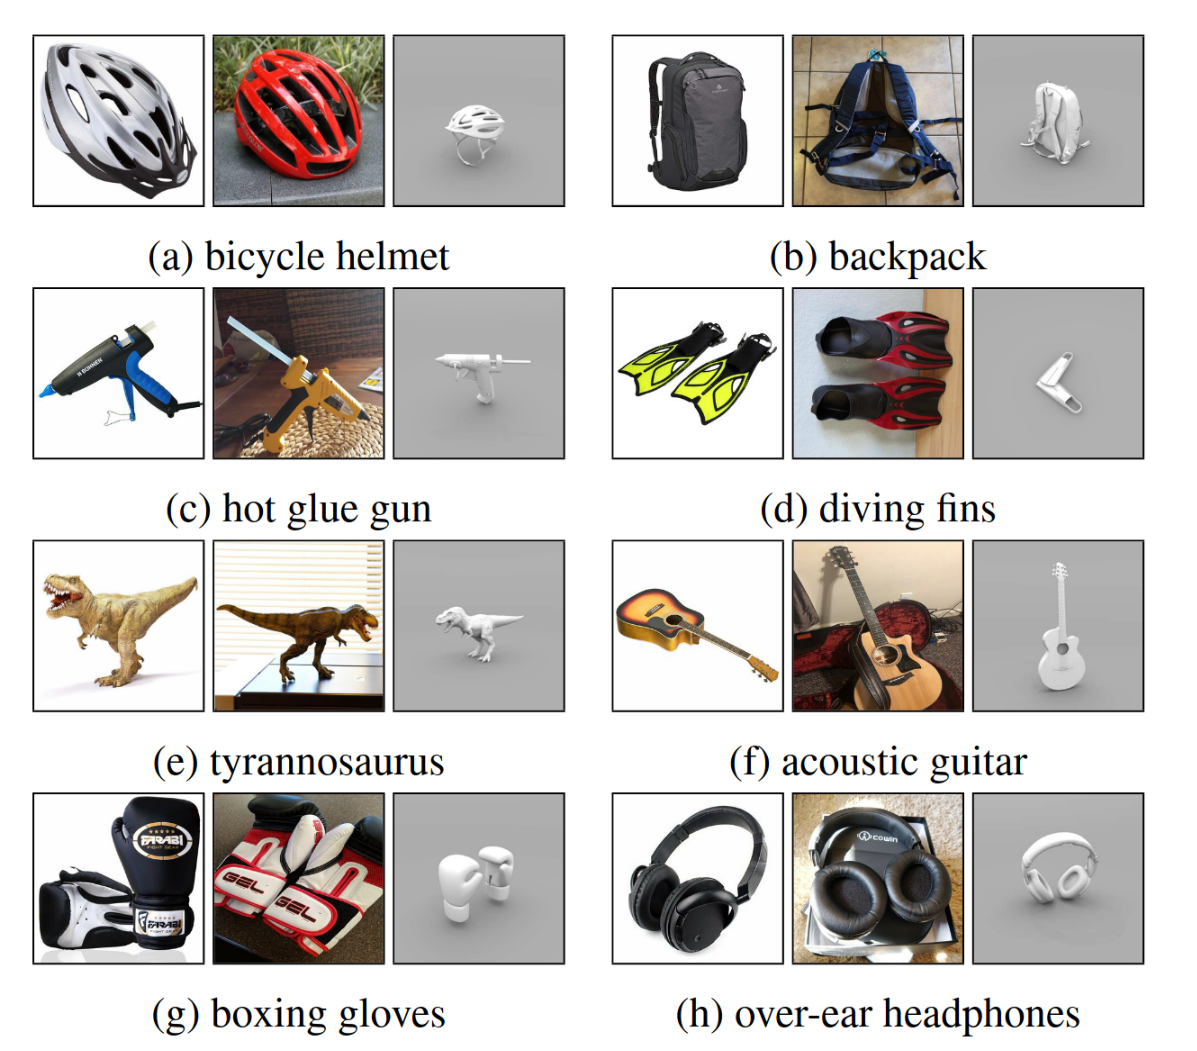

By reducing the number of classes in the dataset and copying only a subset of the original files, the resulting dataset is smaller and more manageable, while still retaining enough diversity to be useful for training a machine learning model.

#### **Import Adaptiope dataset**

The "dataset" directory is created by this code, which also copies the "Adaptiope.zip" file from a Google Drive folder to the "dataset" directory. The "Adaptiope.zip" file is unzipped and a new directory named "adaptiope_small" is created.

In [ ]:
# Create a new directory called "dataset"
!mkdir dataset

# Copy the file "Adaptiope.zip" from the Google Drive folder "deep" to the "dataset" directory
!cp "/content/drive/MyDrive/deep/Adaptiope.zip" dataset/

# Unzip the "Adaptiope.zip" file in the "dataset" directory
!unzip  dataset/Adaptiope.zip #/dev/null

# Remove any existing directory called "adaptiope_small"
!rm -rf adaptiope_small

# Create a new directory called "adaptiope_small"
!mkdir adaptiope_small

# Define a list of class names
classes = ["backpack", "bookcase", "car jack", "comb", "crown", "file cabinet", "flat iron", "game controller", "glasses",
           "helicopter", "ice skates", "letter tray", "monitor", "mug", "network switch", "over-ear headphones", "pen",
           "purse", "stand mixer", "stroller"]

# Loop through the directories "Adaptiope/product_images" and "Adaptiope/real_life"
for d, td in zip(["Adaptiope/product_images", "Adaptiope/real_life"], ["adaptiope_small/product_images", "adaptiope_small/real_life"]):

    # Create a new directory in the "adaptiope_small" directory for each class
    makedirs(td)

    # Loop through each class
    for c in tqdm(classes):

        # Get the path to the current class directory
        c_path = join(d, c)

        # Get the target path for the current class directory in the "adaptiope_small" directory
        c_target = join(td, c)

        # Copy the contents of the current class directory to the corresponding directory in "adaptiope_small"
        copytree(c_path, c_target)

Output streaming troncato alle ultime 5000 righe.
  inflating: Adaptiope/synthetic/purse/purse_1_19.png  
  inflating: Adaptiope/synthetic/purse/purse_2_16.png  
  inflating: Adaptiope/synthetic/purse/purse_4_16.png  
  inflating: Adaptiope/synthetic/purse/purse_3_03.png  
  inflating: Adaptiope/synthetic/purse/purse_3_16.png  
  inflating: Adaptiope/synthetic/purse/purse_1_17.png  
  inflating: Adaptiope/synthetic/purse/purse_2_05.png  
  inflating: Adaptiope/synthetic/purse/purse_3_08.png  
  inflating: Adaptiope/synthetic/purse/purse_2_07.png  
  inflating: Adaptiope/synthetic/purse/purse_2_17.png  
  inflating: Adaptiope/synthetic/purse/purse_3_00.png  
  inflating: Adaptiope/synthetic/purse/purse_1_09.png  
  inflating: Adaptiope/synthetic/purse/purse_4_18.png  
  inflating: Adaptiope/synthetic/purse/purse_3_05.png  
  inflating: Adaptiope/synthetic/purse/purse_3_01.png  
  inflating: Adaptiope/synthetic/purse/purse_4_08.png  
  inflating: Adaptiope/synthetic/purse/purse_4_09.png 

100%|██████████| 20/20 [00:04<00:00,  4.29it/s]


#### **Datasets and Dataloaders**

The Dataset and DataLoader classes in PyTorch are used to manage data processing and loading for machine learning operations.A Dataset is a collection of data samples while a DataLoader is used to load and group these samples into batches for training or testing.

The dataset in this specific code snippet is made up of pictures, which are loaded and processed using PyTorch's ImageFolder and transformations classes. In this instance, the source and target photos are each contained in their own directories, source_dir and target_dir.

To preprocess the input before feeding it to the neural network, the transforms module offers a number of picture modification operations. In this instance, the photos are scaled down to $224$x$224$ pixels and then transformed using the Resize and ToTensor transformations into PyTorch tensors.

The Subset class is used to divide up the datasets into smaller subsets for training and testing after the datasets have been prepared. The data is then loaded and organized into batches using DataLoader objects made from the training and testing subsets. The neural network is then trained and tested using the batches.

The code produces train/validation/test splits for both the source domain and the target domain. The percentage of this split is given and it is equal respectively to 80% for the train and 20% for the test.

In [ ]:
import torchvision.transforms as T

# Set the data directory paths
data_dir = "adaptiope_small"

# Specify the directory where the source images are saved
product = os.path.join(data_dir, "product_images")

# Specify the directory where the target images are saved
real_life = os.path.join(data_dir, "real_life")

transform = list()
# resize each PIL image to 256 x 256
transform.append(T.Resize((256, 256)))
# randomly crop a 224 x 224 patch
transform.append(T.RandomCrop((224, 224)))
# convert Numpy to Pytorch Tensor
transform.append(T.ToTensor())
# normalize with ImageNet mean & std
transform.append(T.Normalize(mean=IMAGENET_MEAN,
                               std=IMAGENET_STD))
transform = T.Compose(transform)

##______________________________________________________________________________
##____________________________________PRODUCT___________________________________
##______________________________________________________________________________
# create the train/validation/test splits for the source domain
# create a dataset object for the source images
product_dataset = ImageFolder(product, transform=transform)

##____________________________________SIZE____________________________________
# get the size of the source dataset
product_dataset_size = len(product_dataset)
# set the size of the training set to 80% of the dataset as required by the assignment
product_train_size = int(product_dataset_size * 0.8)
# set the size of the test set to the remaining 20%
product_test_size = product_dataset_size - product_train_size

##____________________________________INDICES____________________________________
# generate random indices for the training set
product_train_indices = random.sample(range(product_dataset_size), product_train_size)
# generate the remaining indices for the test set
product_test_indices = list(set(range(product_dataset_size)) - set(product_train_indices))

##____________________________________SUBSETS____________________________________
# create a Subset object for the source training set
product_train_dataset = Subset(product_dataset, product_train_indices)
# create a Subset object for the source test set
product_test_dataset = Subset(product_dataset, product_test_indices)

##______________________________________________________________________________
##____________________________________REAL_LIFE____________________________________
##______________________________________________________________________________
# create the train/validation/test splits for the target domain
# create a dataset object for the target images
real_life_dataset = ImageFolder(real_life, transform=transform)


##____________________________________SIZE____________________________________
# get the size of the target dataset
real_life_size = len(real_life_dataset)

# set the size of the training set to 80% of the dataset
real_life_train_size = int(real_life_size * 0.8)
# set the size of the test set to the remaining 20%
real_life_test_size = real_life_size - real_life_train_size

##____________________________________INDICES____________________________________
# generate random indices for the training set
real_life_train_indices = random.sample(range(real_life_size), real_life_train_size)
# generate the remaining indices for the test set
real_life_test_indices = list(set(range(real_life_size)) - set(real_life_train_indices))


##____________________________________SUBSETS____________________________________
# create a Subset object for the target training set
real_life_train_dataset = Subset(real_life_dataset, real_life_train_indices)
# create a Subset object for the target test set
real_life_test_dataset = Subset(real_life_dataset, real_life_test_indices)


##____________________________________DATA LOADERS____________________________________
# create the data loaders for each dataset
# create a data loader for the source training set
product_train_loader = DataLoader(product_train_dataset, batch_size, shuffle=True, drop_last=True, generator=g)

# create a data loader for the target training set
real_life_train_loader = DataLoader(real_life_train_dataset, batch_size, shuffle=True, drop_last=True, generator=g)

# create a data loader for the source test set
product_test_loader = DataLoader(product_test_dataset, batch_size, shuffle=False, generator=g)

# create a data loader for the target test set
real_life_test_loader = DataLoader(real_life_test_dataset, batch_size, shuffle=False, generator=g)

## **Task**

As already stated, the goal of this challenge is to learn a function $F(θ):X⟶Y$ that efficiently handles target data and maps input pictures $X$ to class labels $Y$.

The source dataset consists of labelled images, whereas the target one is unlabeled. The model needs to be trained supervised on source, unsupervised on the training set of target, and evaluated on the test set of target.

The adopted domain alignment strategy is generally evaluated with respect to the gain that it enables over the source-only performance. As the name suggests, the source-only baseline that should be taken into account when evaluating any UDA framework simply consists of the score obtained when training your model on the source domain and evaluating it on the target domain, without
any domain alignment strategy involved.

The steps are the following:


*   Implement a deep learning framework for object recognition

*   Train your framework supervisedly on the source domain and evaluate it, as it is, on the target domain (source only version)

*   Implement and plug into your framework a domain alignment strategy of your own choice, which should allow to benefit from learning unsupervisedly from the target training set

*   Train the final model and evaluate it on the target domain





### **First step**

As baseline we have decided to use ResNet 18, which is particularly suitable for object detection tasks.

Why is Resnet18 particularly convenient? The issue of vanishing gradients occurs frequently during training with back propagation and gradient descent. What happens is that the gradient, while flowing through the layers of the neural network, is subject to a cascade of arithmetic operations which can potentially reduce its magnitude to such a low value that it could affect negatively the performance of the network or even saturate the learning process.

One solution to this problem is the use of residual blocks. These are made of so-called skip connections, which connect the outputs of one layer to succeeding levels by skipping some intermediary ones and doing so not wasting efforts in learning certain connections (such as identity). During this connection-skipping phase, the network is compacted, accelerating learning. After being compressed, the layers expand, enabling the rest of the nodes of the NN to explore a bigger feature area. So, the gradient can move more fluidly while still maintaining rather significant values. Additionally, residual blocks introduce the idea of learning residuals, which entails going beyond only the mapping function to try to predict the residues resulting by the difference between the input and the output and allowing the network to master even more complex functions.

Resnets are made of residual blocks and are categorized as directed acyclic graphs network because of their complex layered structure, predefined input size of $224$ x $224$ x $3$, and the fact that layers take input from and give output to several other layers.

Resnet18 is a network that has gained a lot of attention because of its ease of use and superior performance on a variety of applications. In contrast to other deep learning systems that have hundreds or even thousands of layers, it is quite simple. As a result, training becomes simpler and faster.

The internal layout consists of $18$ layers, of which $16$ convolutional and $2$ fully connected at the end. The first layer has a dimension of $7$ x $7$ with a stride of $2$, which reduces the size of the input image in half. The succeeding one is max-pooling with a $3$ x $3$ filter and a stride of $2$. Four groups of convolutional blocks, each with two to three convolutional layers, receive the output of this layer. The final layer in each of these groups incorporates batch normalization, average pooling layer and ReLu as activation function. The last layer of this network has an output size equal to the $20$ classes of the dataset.

A dropout layer has been added in order to limit the issue of overfitting.

Sources:

*   https://pytorch.org/vision/stable/models.html
*   https://stackoverflow.com/questions/55083642/extract-features-from-last-hidden-layer-pytorch-resnet18



In [ ]:
WEIGHTS_RESNET18 = "IMAGENET1K_V1"
import torchvision.models as models

class ResNet18(nn.Module):

    def __init__(self, num_classes, dropout_prob=0.5):
        super().__init__()

        # Load the pretrained ResNet-18 model.
        self.resnet = models.resnet18(pretrained=True)

        # Extract the feature extractor part of the ResNet (excluding the final classification layer).
        # It includes all layers except the last one.
        self.feature_extractor = nn.Sequential(*list(self.resnet.children())[:-1])

        # Define the classifier part as a sequential model consisting of:
        # - A Linear layer reducing the number of features to 256.
        # - A ReLU activation function.
        # - A Linear layer that maps 256 features to 'num_classes' output classes.
        self.classifier = nn.Sequential(nn.Linear(512, 256), nn.ReLU(), nn.Linear(256, num_classes))

    def forward(self, x):

        # Pass the input through the feature extractor.
        x = self.feature_extractor(x)

        # Flatten the output of the feature extractor to shape (batch_size, -1).
        x = x.view(x.size(0), -1)

        # Pass the flattened output through the classifier to get the final output.
        x = self.classifier(x)
        return x

    def forward_features(self, x):

        # Pass the input through the feature extractor.
        x = self.feature_extractor(x)

        # Flatten the output of the feature extractor to shape (batch_size, -1).
        x = x.view(x.size(0), -1)
        return x

#### **Model instantation**

Here we instantiate the model and we define the optimizer and the loss we are going to use. Namely as optimizer NTASGD has been selected and as criterion the Cross Entropy Loss.

The traditional SGD has been replaced with a slightly different version of it: Non-monotone Target-Adaptive Stochastic Gradient Descent (NT-ASGD). It is designed specifically to improve the convergence rate of SGD in non-convex optimization problems ad introduces a target update rule that adaptively adjusts the learning rate based on the performance of the current iteration compared to the previous iteration. Taking the average is a method which helps the stabilization of the training and improves the final performance of the model. To ensure that the averaging process does not significantly influence the stability of the neural network weights, it is important to perform averaging at a point during training when the weights have reached a consistent value. One strategy for determining when to average the weights is to monitor the model's performance on a validation set. When the validation metric fails to improve for multiple cycles, averaging can be initiated. This technique requires the use of two additional hyperparameters: L, which represents the logging interval (typically set to the number of iterations in an epoch), and n, a non-monotone interval (commonly set to 5). These hyperparameters are used to help ensure that the randomness of the training process does not significantly impact the decision to average the weights.

However this optimizer in this case has been used just as a trial on the baseline, since the results gained were not much different, the accuracies printed for all the models are the ones from the classical Stochastic Gradient Descent.

Regarding the choice of cross entropy, it is often used to optimize classification models and it is built upon entropy by computing the difference between two probability distributions.

$-∑t_i log(p_i)$, for $n$ classes, where $t_i$ is the truth label and $p_i$ is the Softmax probability for the $i^{th}$ class.

https://github.com/salesforce/awd-lstm-lm/blob/32fcb42562aeb5c7e6c9dec3f2a3baaaf68a5cb5/main.py#L275

In [ ]:
class NTASGD(optim.Optimizer):

    """
    A custom Pytorch optimizer called NTASGD (non-monotonically triggered adaptive SGD)
    that inherits from the built-in Pytorch optimizer class optim.Optimizer.
    """

    def __init__(self, params, lr=1, n=5, weight_decay=0, fine_tuning=False):

        """
        Initializes the optimizer with the given parameters.

        Parameters
        ----------
        params : list of torch.Tensor
            The parameters of the model to optimize
        lr : float, optional
            The learning rate of the optimizer, by default 1
        n : int, optional
            The number of previous steps to consider when checking the non-monotonic condition, by default 5
        weight_decay : float, optional
            The weight decay of the optimizer, by default 0
        fine_tuning : bool, optional
            Whether the optimizer is in fine-tuning mode or not, by default False
        """

        # Set the default values for the hyperparameters
        self.defaults = dict(
            lr=lr,
            n=n,
            weight_decay=weight_decay,
            fine_tuning=fine_tuning,
            t0=10e7 if not fine_tuning else 0,
            t=0,
            logs=[]
        )

        # Initialize the optimizer
        super().__init__(params, self.defaults)


    # Check if the current iteration satisfies the non-monotonic condition.
    def check(self, v):

        """
        Check if the current iteration satisfies the non-monotonic condition.

        Parameters
        ----------
        v : float
            The current iteration's value

        Returns
        -------
        bool
            True if the non-monotonic condition is triggered, False otherwise
        """

        for group in self.param_groups:

            # Check if the current group is in fine-tuning mode or if it is not in fine-tuning mode
            # and the non-monotonic condition has not been triggered yet
            if group["fine_tuning"] or (not group["fine_tuning"] and group["t0"] == 10e7):

                # Check if the current iteration is past the n-th iteration and if the current value is
                # greater than the minimum of the last n logs
                if group["t"] > group["n"] and v > min(group["logs"][:-group["n"]]):

                    group["t0"] = self.state[next(iter(group["params"]))]["step"]

                    print("Non-monotonic condition is triggered!")

                    return True

                group["logs"].append(v)

                group["t"] += 1

    # Set the learning rate for the optimizer
    def lr(self, lr):

        """
        Set the learning rate for the optimizer.

        Parameters
        ----------
        lr : float
            The new learning rate
        """

        for group in self.param_groups:
            group["lr"] = lr


    # Perform a single optimization step
    def step(self):

        """
        Perform a single optimization step for all parameters in the groups.
        """

        for group in self.param_groups:

            for p in group["params"]:

                # Get the gradient of the parameter
                grad = p.grad.data

                # Get the state of the parameter
                state = self.state[p]

                # Initialize the state if it is empty
                if len(state) == 0:

                    state["step"] = 0

                    state["mu"] = 1

                    state["ax"] = torch.zeros_like(p.data)

                # Increment the step counter
                state["step"] += 1

                # Apply weight decay if specified
                if group["weight_decay"] != 0:

                    grad = grad.add(group["weight_decay"], p.data)

                # Update the parameter
                p.data.add_(-group["lr"], grad)

                # Update the moving average parameter
                if state["mu"] != 1:

                    state["ax"].add_(p.data.sub(state["ax"]).mul(state["mu"]))

                else:

                    state["ax"].copy_(p.data)

                state["mu"] = 1 / max(1, state["step"] - group["t0"])

The boolean variable "std_optimizer" is used in order to distinguish between the standard Stochastic Gradient Descent and its modified version, the Non-monotone Target-Adaptive Stochastic Gradient Descent.



In [ ]:
# Set the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set some parameters
epochs = 32
learning_rate = 0.01
weight_decay = 5e-4
momentum = 0.9
stop = 5
fine_tuning = False
chk_monotonic = 5
std_optimizer = False
threshold = 0.9

# Loss funtion
cost_function = nn.CrossEntropyLoss()

### **Second step**

#### **Training Step**

The code sample under review accepts a variety of inputs, including a cost function, a data loader, an optimizer, and a neural network model.

Iterating over batches of data from the training set is what the training step entails. This is accomplished by the code sample running through the batches and then putting the inputs and targets onto the GPU memory for CUDA-enabled devices for faster calculation. The importance of employing batches is due to memory restrictions and a greater capacity for generalization. Data loading in batches is computationally possible, especially for big datasets.

The network does a forward pass on each iteration in order to produce predictions for the input batch. By contrasting these forecasts with the actual targets, the cost function calculates the loss. The gradients are then computed with regard to the loss and utilized during the backpropagation procedure. With each iteration, the optimizer updates the model parameters in order to get the predictions of the model closer to the actual values.

In addition to backpropagation, the code sample evaluates the model's effectiveness by contrasting the expected class labels with the actual class labels. This gives information on the model's precision for the current batch. The function calculates the average loss and accuracy for the entire training dataset by keeping track of cumulative loss and accuracy.

The data loader and dataset classes are one of PyTorch's core features that the code sample makes use of. The data loader facilitates the simple loading and preprocessing of datasets, which is especially important for sizable datasets that require more RAM than is available. With capabilities for image scaling and conversion, the dataset class offers a consistent interface for importing and preprocessing data. These classes greatly simplify the process of incorporating data from numerous sources into a PyTorch training pipeline.

In [ ]:
def training_step(net, data_loader, optimizer, std_optimizer, cost_function, device='cuda'):

  samples = 0.
  cumulative_loss = 0.
  cumulative_accuracy = 0.

  # set the network to training mode
  net.train()

  # iterate over the training set
  for batch_idx, (inputs, labels) in enumerate(data_loader):

    # load data into GPU
    inputs = inputs.to(device)
    labels = labels.to(device)

    # gradients reset
    optimizer.zero_grad()

    # forward pass
    outputs = net(inputs)

    # loss computation
    loss = cost_function(outputs,labels)

    # backward pass
    loss.backward()

    if std_optimizer:
      # parameters update
      optimizer.step()
    else:
      # parameters update
      for p in optimizer.param_groups[0]['params']:
        if p.grad is not None:
            p.data.add_(-optimizer.param_groups[0]['lr'], p.grad.data)


    # fetch prediction and loss value
    samples += inputs.shape[0]
    cumulative_loss += loss.item()
    _, predicted = outputs.max(dim=1) # max() returns (maximum_value, index_of_maximum_value)

    # compute training accuracy
    cumulative_accuracy += predicted.eq(labels).sum().item()


  return cumulative_loss/samples, cumulative_accuracy/samples*100

#### **Testing Step**

The test_step() assesses the model's performance on the testing dataset.

Initializing variables for the total loss, total accuracy, and total samples processed is the first step. The eval() procedure is then called, putting the network into evaluation mode. This is so that the parameters of the model do not change during testing based on the gradients of the loss function. In contrast, they are modified to reduce loss in the training mode.

Since gradient computation is not required during testing, we next turn it off by calling torch.no_grad(). The function then uses a loop to go across the testing set, loading batches of inputs and targets using the to() method. The output predictions are then compared to the targets using the cost function to determine the loss after the inputs have been processed through the network.

The outputs of the network are used to update the number of samples processed, cumulative loss, and cumulative accuracy, much like in the training_step() method. In addition, the function provides a quantitative evaluation of the model's performance on the test dataset by returning the average loss and accuracy across all the samples it has processed.

In [ ]:
def test_step(net, data_loader, optimizer, cost_function, device='cuda'):

  samples = 0.
  cumulative_loss = 0.
  cumulative_accuracy = 0.

  # set the network to evaluation mode
  net.eval()

  # disable gradient computation (we are only testing, we do not want our model to be modified in this step!)
  with torch.no_grad():

    # iterate over the test set
    for batch_idx, (inputs, targets) in enumerate(data_loader):

      # load data into GPU
      inputs = inputs.to(device)
      targets = targets.to(device)

      # forward pass
      outputs = net(inputs)

      # loss computation
      loss = cost_function(outputs, targets)

      # fetch prediction and loss value
      samples+=inputs.shape[0]
      cumulative_loss += loss.item() # Note: the .item() is needed to extract scalars from tensors
      _, predicted = outputs.max(1)

      # compute accuracy
      cumulative_accuracy += predicted.eq(targets).sum().item()


  return cumulative_loss/samples, cumulative_accuracy/samples*100

#### **Early Stopping**


Early stopping is a technique used to prevent overfitting and it is based on the idea that the model's performance on the validation set will stop improving after a certain number of training epochs, and continuing to train beyond this point will only lead to overfitting.

In this case the monitor is on the perplexity: after three times we see the perplexity increasing we stop the training and get the final value.

There are several benefits to using early stopping:



*   It can help prevent overfitting by stopping the training process before the model starts to overfit the training data;
*   It can save time and resources by avoiding the need to train the model for a large number of epochs;
*   It can improve the generalization ability of the model by avoiding the use of models that are overfitted to the training data.

In [ ]:
class EarlyStopping:

  """
    A class for early stopping of training process.

    Args:
        patience (int): Number of epochs to wait before triggering early stopping. Default: 5
        verbose (bool): Flag indicating whether to print messages when early stopping is triggered. Default: True

    Attributes:
        patience (int): Number of epochs to wait before triggering early stopping.
        verbose (bool): Flag indicating whether to print messages when early stopping is triggered.
        counter (int): Counter for the number of epochs since the last improvement.
        best_score (float): Best score seen so far. None by default.
  """

  def __init__(self, patience=5, verbose=True):

    # set the number of epochs to wait before triggering early stopping
    self.patience = patience

    # set a flag indicating whether to print messages when early stopping is triggered
    self.verbose = verbose

    # initialize the counter for the number of epochs since the last improvement
    self.counter = 0

    # initialize the best score seen so far to None
    self.best_score = None

  def step(self, val_loss):
    """
        Function to check if early stopping should be triggered.

        Args:
            val_loss (float): Current validation loss.

        Returns:
            bool: Whether early stopping should be triggered or not.
    """

    # if this is the first epoch, set the best score to the current validation loss
    if self.best_score is None:

      self.best_score = val_loss

    # if the current validation loss is worse than the best score seen so far
    elif val_loss > self.best_score:

      # increment the counter
      self.counter += 1

      # if the counter has reached the patience threshold
      if self.counter >= self.patience:

        # if verbose is True, print a message indicating that early stopping has been triggered
        if self.verbose:

          print(f'Early stopping triggered with counter {self.counter} and patience {self.patience}')

        # return True to indicate that early stopping should be triggered
        return True

    # if the current validation loss is better than the best score seen so far

    else:

      # set the best score to the current validation loss
      self.best_score = val_loss

      # reset the counter
      self.counter = 0

    # if the counter has not reached the patience threshold, return False
    return False

#### **Main**

By invoking the training_step and test_step functions, keeping track of the training progress, and reporting the model's ultimate performance on the training and test sets, the main function is in charge of coordinating the training process.

The main function performs a single test step to assess the model's initial performance on both the training and test sets before beginning the training loop. This process aids in establishing the model's baseline performance prior to any training. The metrics, including the training and test losses and accuracies, are then printed out by the function.

After that, the main function loops through the predetermined number of epochs.

The main function executes a further test step once training is finished to assess the model's final performance on the training and test sets.

In [ ]:
def main(net,
          batch_size,
          device,
          learning_rate,
          weight_decay,
          momentum,
          chk_monotonic,
          fine_tuning,
          std_optimizer,
          epochs,
          train,
          test,
          cost_function,
          early_stopping_patience):

    # Optimizer choise
    if std_optimizer:
      optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
    else:
      optimizer = NTASGD(net.parameters(), learning_rate, chk_monotonic, weight_decay, fine_tuning)
      #Adjust the learning rate
      optimizer.lr(learning_rate)



    # create an instance of the EarlyStopping class
    early_stopping = EarlyStopping(patience=early_stopping_patience)

    # run a single test step beforehand and print metrics
    print('Before training:')
    train_loss, train_accuracy = test_step(net, globals()[train+'_train_loader'], optimizer,  cost_function)
    test_loss, test_accuracy = test_step(net, globals()[test+'_test_loader'], optimizer, cost_function)

    print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
    print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
    print('-----------------------------------------------------')

    loss_value = 10e6
    accuracy_value = 0.
    loss_train = []
    loss_test = []
    accuracy_train = []
    accuracy_test = []
    path = F"/content/drive/MyDrive/deep/trained_models/"

    # iterate over the number of epochs
    for e in range(epochs):

        # train & log
        train_loss, train_accuracy = training_step(net, globals()[train+'_train_loader'], optimizer, std_optimizer, cost_function)
        loss_train.append(train_loss)
        accuracy_train.append(train_accuracy)

        test_loss, test_accuracy = test_step(net, globals()[test+'_test_loader'], optimizer, cost_function)
        loss_test.append(test_loss)
        accuracy_test.append(test_accuracy)

        print('Epoch: {:d}'.format(e+1))
        print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
        print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
        print('-----------------------------------------------------')

        if test_loss < loss_value:
            torch.save(net.state_dict(), path + 'best_' + train + '_' + test + '.pth')
            loss_value = test_loss
            accuracy_value = test_accuracy

        # call the step method of the EarlyStopping class
        if early_stopping.step(test_loss):
            print("Early stopping triggered")
            break

    epoch = list(range(1, len(accuracy_test)+1))

    # Series
    plt.plot(epoch, accuracy_train, label=train, color='blue')
    plt.plot(epoch, accuracy_test, label=test, color='red')

    # Title of Graph
    plt.title('Train: '+ train + ' - Test: ' + test)
    plt.legend()

    # Labels
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    # Print
    plt.show()


    # Series
    plt.plot(epoch, loss_train, label=train, color='blue')
    plt.plot(epoch, loss_test, label=test, color='red')

    # Title of Graph
    plt.title('Train: '+ train + ' - Test: ' + test)
    plt.legend()

    # Labels
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    # Print
    plt.show()

    return loss_value, accuracy_value


#### **Predict**

The trained neural network is used to make predictions through this so-called function "predict".

As its initial action, Predict invokes net.eval() to put the neural network into evaluation mode. In the assessment mode, dropout layers and other network components that are only significant during training are disabled. After initialization, the predicted and true labels, y_pred and y_true, are set up to be kept in respective empty lists.

Since we are only making predictions at this point and not training the model, the iteration loop is enclosed in a torch.no_grad() context to prevent gradient computation. inputs = inputs when using.targets equal targets and to(device).Each time the data loader iterates, the inputs and targets are loaded in batches into the selected device, to(device).

Following that, during the forward pass, the inputs are sent across the network with outputs equal to net(inputs). Outputs = predicted.The anticipated class labels are extracted using max(dim=1), where max gives the maximum value and index along the given dimension. The predicted and true labels are then added to the corresponding lists, y_pred and y_true, respectively.
After all the data has been examined, the return y_pred, y_true function is used to return the predicted and true labels as lists.

In [ ]:
def predict(net, dl, device='cuda'):

    # set the network to evaluation mode
    net.eval()
    data_loader = globals()[dl+'_test_loader']

    # initialize empty lists to store predicted and true labels
    y_pred = []
    y_true = []

    # disable gradient computation (we are only predicting, we do not want our model to be modified in this step!)
    with torch.no_grad():

        # iterate over the data loader
        for batch_idx, (inputs, targets) in enumerate(data_loader):

            # load data into GPU
            inputs = inputs.to(device)
            targets = targets.to(device)

            # forward pass
            outputs = net(inputs)
            # retrieve the predicted class labels
            _, predicted = outputs.max(dim=1)

            # append predicted and true labels to their corresponding lists
            y_pred += predicted.cpu().numpy().tolist()
            y_true += targets.cpu().numpy().tolist()

    # return the predicted and true labels as lists
    return y_pred, y_true

####**Evaluation**

In the following section several metrics are tested so as to prove the performance of the baseline and the three domain adaptations techniques used.

Specifically, the metrics chosen are as follows:

*   Confusion Matrix;
*   Roc Curve;
*   Predicted labels.

Let's see them in details.


##### **Confusion Matrix**

A confusion matrix is a table that is used to evaluate the performance of a classification model. It is a way to visualize the number of true positives, false positives, true negatives, and false negatives that are produced by a model's predictions.

It has two dimensions: the actual values and the predicted values.

The actual values are the true labels of the data, while the predicted values are the labels that the model has assigned to the data.

The four components of the confusion matrix are:



*  True positives (TP): The number of positive instances that were correctly classified as positive by the model;
*  False positives (FP): The number of negative instances that were incorrectly classified as positive by the model;
*  True negatives (TN): The number of negative instances that were correctly classified as negative by the model;
*  False negatives (FN): The number of positive instances that were incorrectly classified as negative by the model.

The confusion matrix provides a way to evaluate how well a classification model is performing, and it is often used to calculate other evaluation metrics such as accuracy, precision, recall, and F1-score.

In [ ]:
def confusion_matrix(y_true, y_pred, num_classes):
    # Initialize a square matrix with dimensions equal to the number of classes
    conf_mat = np.zeros((num_classes, num_classes))

    # Iterate over each element in y_true and y_pred
    for i in range(len(y_true)):
        # Get the true and predicted class labels for the i-th element
        true_class = int(y_true[i])
        pred_class = int(y_pred[i])

        # Increment the corresponding entry in the confusion matrix
        conf_mat[true_class, pred_class] += 1

    # Return the resulting confusion matrix
    return conf_mat

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes):
    # Compute confusion matrix
    num_classes=len(classes)
    conf_mat = confusion_matrix(y_true, y_pred, num_classes)

    # Create heatmap
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(conf_mat, annot=True, fmt='.2f', cmap='Blues', square=True, cbar=False, ax=ax)

    # Set labels and ticks
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.set_xticklabels(classes, rotation=90)
    ax.set_yticklabels(classes, rotation=0)

    plt.show()

##### **Roc Curve**

A binary classification model's performance is assessed using a graph known as the ROC curve (Receiver Operating Characteristic curve). The ratio of true positives (True Positive Rate) to false positives (False Positive Rate) is used to plot the curve.

The model is assessed using a set of test data, and the True Positive Rate and False Positive Rate are computed for each potential classification threshold in order to obtain the ROC curve.

The ROC curve is a graphical representation of the rates of true positives and false positives as the classification threshold changes.

Specifically, the area under the ROC curve (AUC, Area Under the Curve) is a performance index that measures the ability of the model to separate positive and negative classes, independently on the choice of the classification threshold.

A model with an area under the ROC curve of 1.0 is able to distinguish perfectly between positive and negative classes, whereas a model with an area under the ROC curve of 0.5 is equal to a model that produces predictions at random.

In [ ]:
def plot_roc_curve(net, dl, num_classes=20, device='cuda'):

    # Set the network to evaluation mode
    net.eval()
    data_loader = globals()[dl+'_test_loader']

    # Set the figure size of the ROC curve plot
    plt.figure(figsize=(17, 12))

    # Iterate over each class index
    for class_idx in range(num_classes):

        # Initialize empty lists to store the true labels and predicted scores for the current class
        y_score = []
        y_true = []

        # Disable gradient computation (we are only predicting, we do not want our model to be modified in this step!)
        with torch.no_grad():

            # Iterate over the data loader
            for batch_idx, (inputs, targets) in enumerate(data_loader):

                # Load data into GPU
                inputs = inputs.to(device)
                targets = targets.to(device)

                # Forward pass to get the model outputs
                outputs = net(inputs)
                class_outputs = outputs[:, class_idx] # Get the predicted scores for the current class
                _, predicted = outputs.max(dim=1)

                # Append predicted scores and true labels to their corresponding lists
                y_score += class_outputs.cpu().numpy().tolist()
                y_true += (targets == class_idx).cpu().numpy().tolist()

        # Compute the false positive rate, true positive rate, and thresholds for the ROC curve
        fpr, tpr, thresholds = roc_curve(y_true, y_score, pos_label=1)

        # Compute the area under the ROC curve
        roc_auc = auc(fpr, tpr)

        # Plot the ROC curve for the current class
        plt.plot(fpr, tpr, lw=2, label='ROC curve for class {} (area = {:0.2f})'.format(class_idx, roc_auc))

    # Plot the diagonal line of the ROC curve for reference
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    # Set the limits of the x and y axes and label them
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    # Set the title and legend for the plot
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")

    # Display the plot
    plt.show()

##### **Predicted labels**

Understanding how machine learning models perform and operate requires the use of visualization. Plotting projected labels is one visualization technique that is particularly effective for examining a model's capacity for classification. This technique basically entails creating a bar chart that displays the distribution of predicted labels across several classes, providing an intuitive understanding of the model's advantages and disadvantages.

In [ ]:
def plot_predicted_labels(net, dl, device='cuda'):

    # Set the network to evaluation mode
    net.eval()
    data_loader = globals()[dl+'_test_loader']

    # Create an empty list to hold the predicted labels
    predicted_labels = []

    # Get class names from the data loader
    classes = data_loader.dataset if isinstance(data_loader.dataset, ImageFolder) else product_dataset.classes #globals()[dl + '_dataset.classes']

    # Iterate over the data in the test_loader
    for batch_idx, (inputs, targets) in enumerate(data_loader):
        # Move the data to the device
        inputs, targets = inputs.to(device), targets.to(device)

        # Compute the outputs of the model
        outputs = net(inputs)

        # Get the predicted labels for this batch
        _, predicted = torch.max(outputs.data, 1)

        # Convert tensor to list and append to predicted_labels
        predicted_labels += predicted.cpu().numpy().tolist()

    # Create a Counter object from the predicted labels list
    predicted_labels_count = Counter(predicted_labels)

    # Create a list of the counts for each class
    counts = [predicted_labels_count[i] for i in range(len(classes))]

    # Plot the bar chart
    plt.figure(figsize=(10,5))
    plt.bar(classes, counts)
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title('Predicted Labels')
    plt.show()

#### **Training the baseline**

In this section the baseline is trained in all the four directions:

*   Real Life  ⟶  Product
*   Product ⟶ Real Life
*   Product ⟶ Product
*   Real Life  ⟶ Real Life

This is done in order to obtain the upper and lower bounds and use them as a term of comparison to test the performance of the techniques of domain adaptations.

In fact, the accuracies gained with them should be in between these two bounds.

For each dimension are reported the results of the three metrics previously described as well as the losses of the training step and the losses and accuracies of the test step.

##### **Real Life $⟶$ Product**

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 265MB/s]


Before training:
	 Training loss 0.04712, Training accuracy 6.62
	 Test loss 0.05318, Test accuracy 6.75
-----------------------------------------------------
Epoch: 1
	 Training loss 0.04545, Training accuracy 13.69
	 Test loss 0.04827, Test accuracy 36.25
-----------------------------------------------------
Epoch: 2
	 Training loss 0.04137, Training accuracy 45.38
	 Test loss 0.04326, Test accuracy 59.75
-----------------------------------------------------
Epoch: 3
	 Training loss 0.03628, Training accuracy 67.00
	 Test loss 0.03664, Test accuracy 77.25
-----------------------------------------------------
Epoch: 4
	 Training loss 0.02995, Training accuracy 78.81
	 Test loss 0.02894, Test accuracy 85.00
-----------------------------------------------------
Epoch: 5
	 Training loss 0.02335, Training accuracy 84.31
	 Test loss 0.02153, Test accuracy 89.25
-----------------------------------------------------
Epoch: 6
	 Training loss 0.01769, Training accuracy 88.06
	 Test loss 0.0165

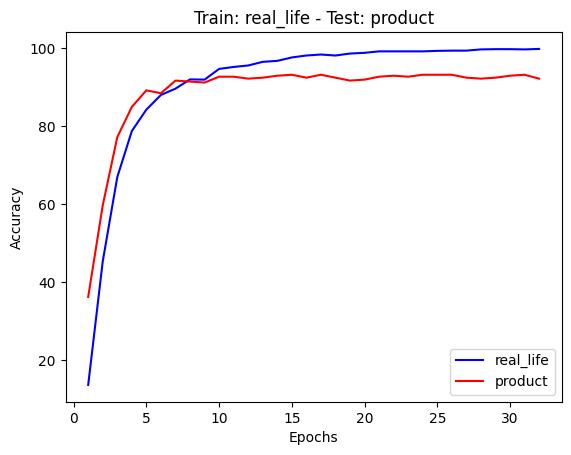

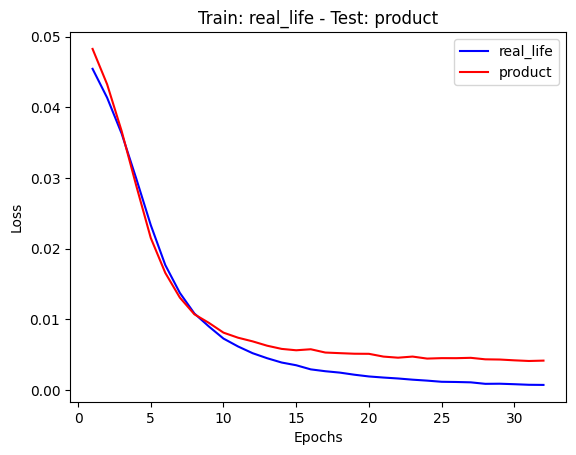

Lower bound after training on Real Life and test on Product is:
	 Test loss 0.00412, Test accuracy 93.25
-----------------------------------------------------


In [ ]:
# Instantiate ResNet18
net = ResNet18(len(classes)).to(device)

loss, accuracy = main(net, batch_size, 'cuda:0', learning_rate, weight_decay, momentum, chk_monotonic, fine_tuning, std_optimizer, epochs, 'real_life', 'product', cost_function, stop)

#print final metrics
print('Lower bound after training on Real Life and test on Product is:')
print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(loss, accuracy))
print('-----------------------------------------------------')


**Predictions**

In [ ]:
y_true, y_pred = predict(net, 'product', device='cuda')

**Confusion Matrix**

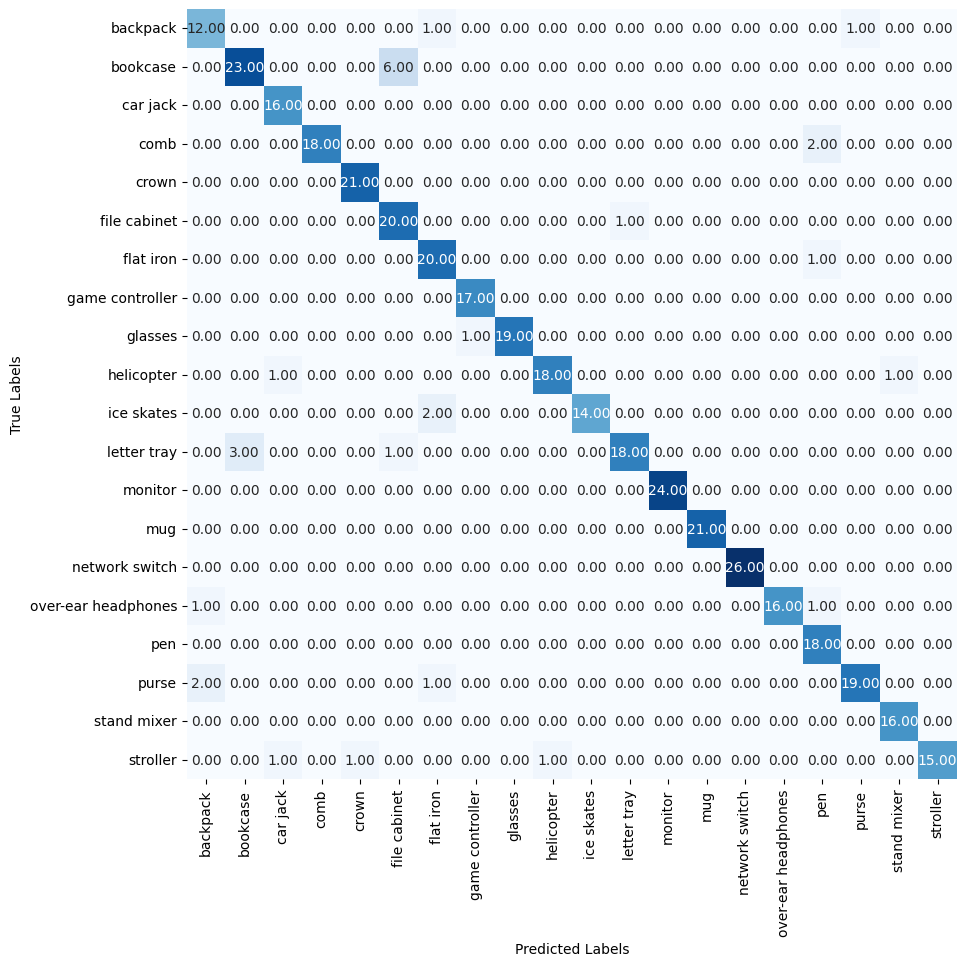

In [ ]:
plot_confusion_matrix(y_true, y_pred, classes)

**Roc Curve**

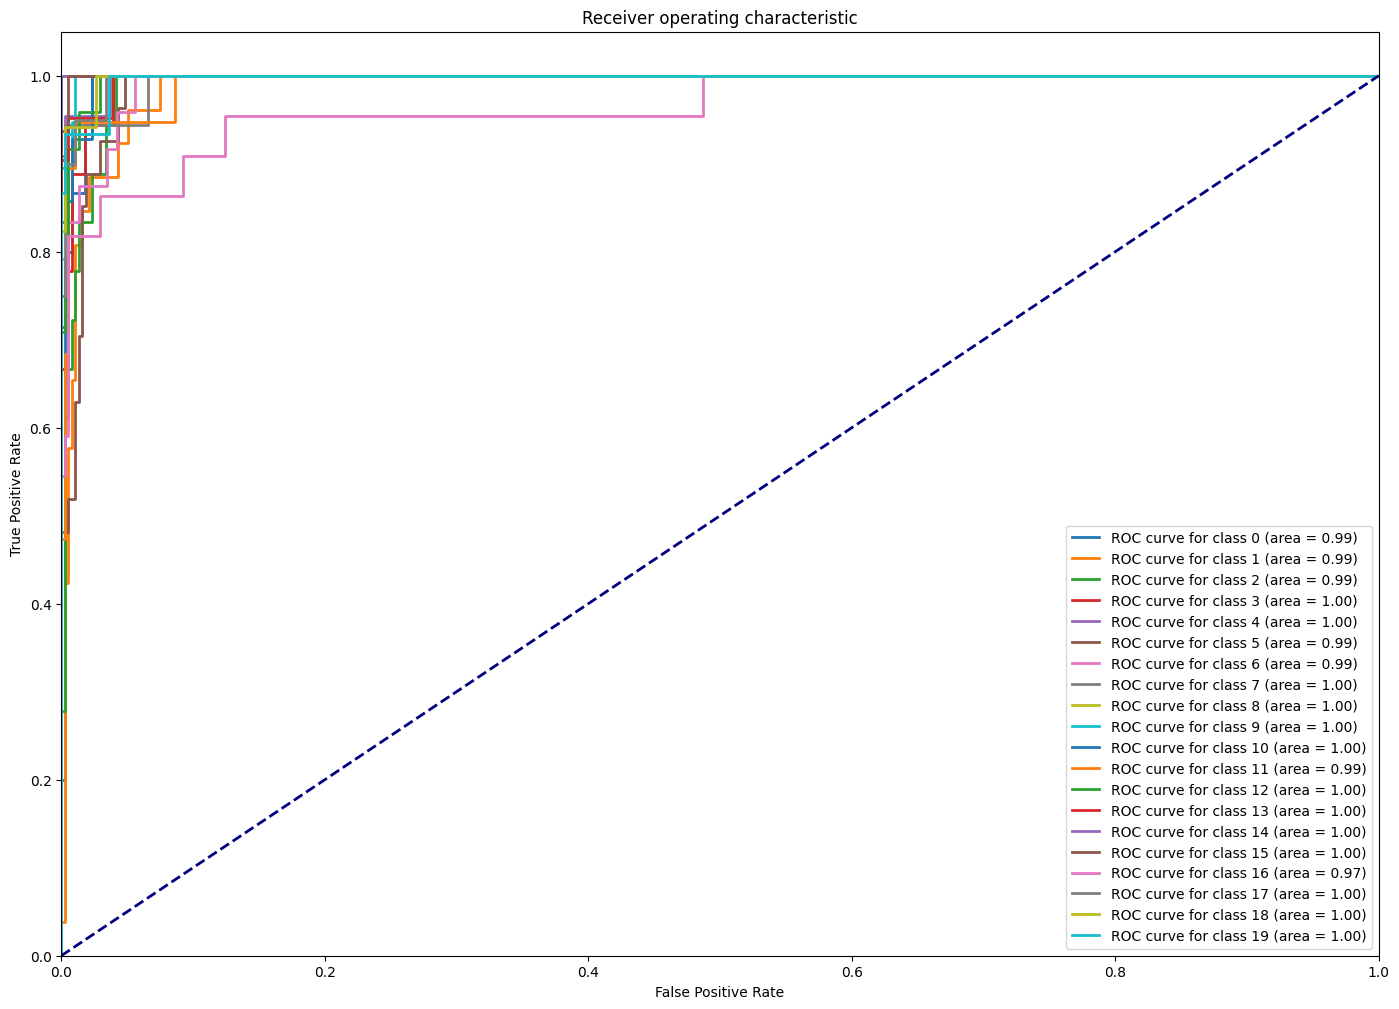

In [ ]:
plot_roc_curve(net, 'product')

**Predicted Labels**

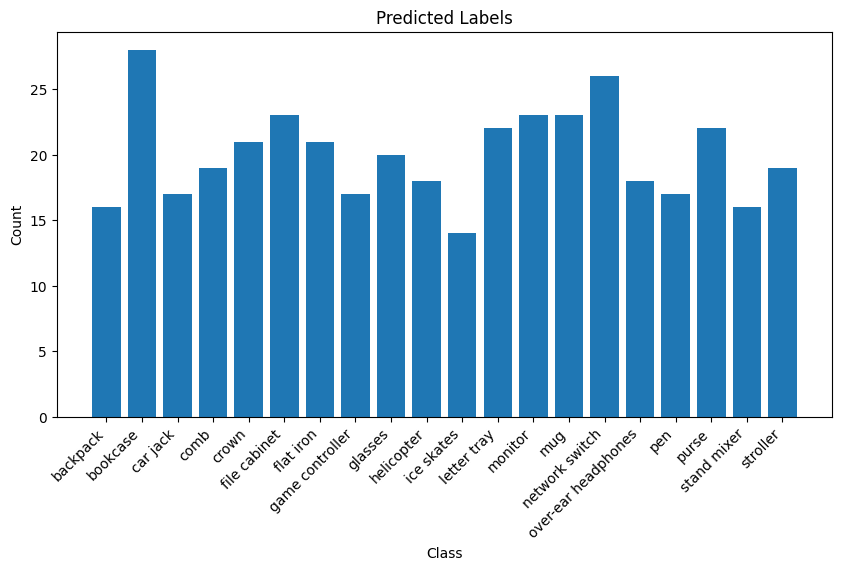

In [ ]:
plot_predicted_labels(net, 'product')

##### **Product $⟶$ Real Life**

Before training:
	 Training loss 0.04699, Training accuracy 6.19
	 Test loss 0.05299, Test accuracy 7.00
-----------------------------------------------------
Epoch: 1
	 Training loss 0.04439, Training accuracy 22.81
	 Test loss 0.04882, Test accuracy 23.75
-----------------------------------------------------
Epoch: 2
	 Training loss 0.03756, Training accuracy 68.94
	 Test loss 0.04454, Test accuracy 46.00
-----------------------------------------------------
Epoch: 3
	 Training loss 0.02894, Training accuracy 87.69
	 Test loss 0.03834, Test accuracy 62.00
-----------------------------------------------------
Epoch: 4
	 Training loss 0.01986, Training accuracy 92.25
	 Test loss 0.03275, Test accuracy 66.75
-----------------------------------------------------
Epoch: 5
	 Training loss 0.01317, Training accuracy 94.06
	 Test loss 0.02793, Test accuracy 68.00
-----------------------------------------------------
Epoch: 6
	 Training loss 0.00924, Training accuracy 95.00
	 Test loss 0.0251

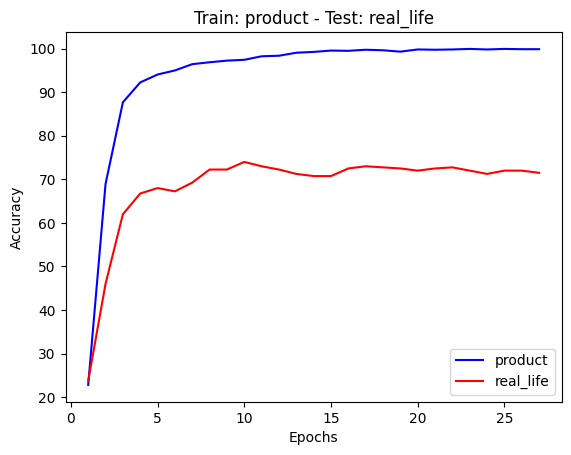

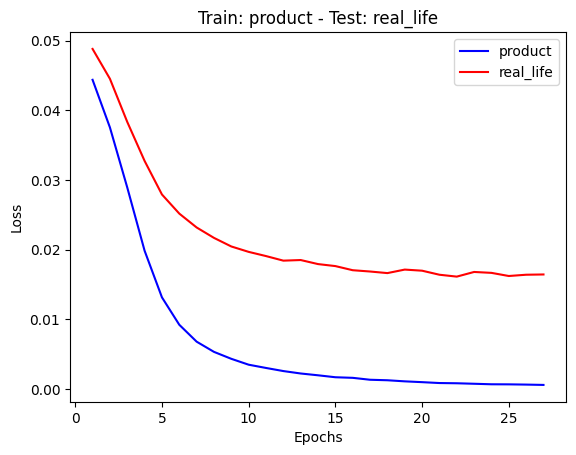

Lower bound after training on Product and test on Real Life is:
	 Test loss 0.01615, Test accuracy 72.75
-----------------------------------------------------


In [ ]:
# Instantiate ResNet18
net = ResNet18(len(classes)).to(device)

loss, accuracy = main(net, batch_size, 'cuda:0', learning_rate, weight_decay, momentum, chk_monotonic, fine_tuning, std_optimizer, epochs, 'product', 'real_life', cost_function, stop)

#print final metrics
print('Lower bound after training on Product and test on Real Life is:')
print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(loss, accuracy))
print('-----------------------------------------------------')


**Predictions**

In [ ]:
y_true, y_pred = predict(net, 'real_life', device='cuda')

**Confusion Matrix**

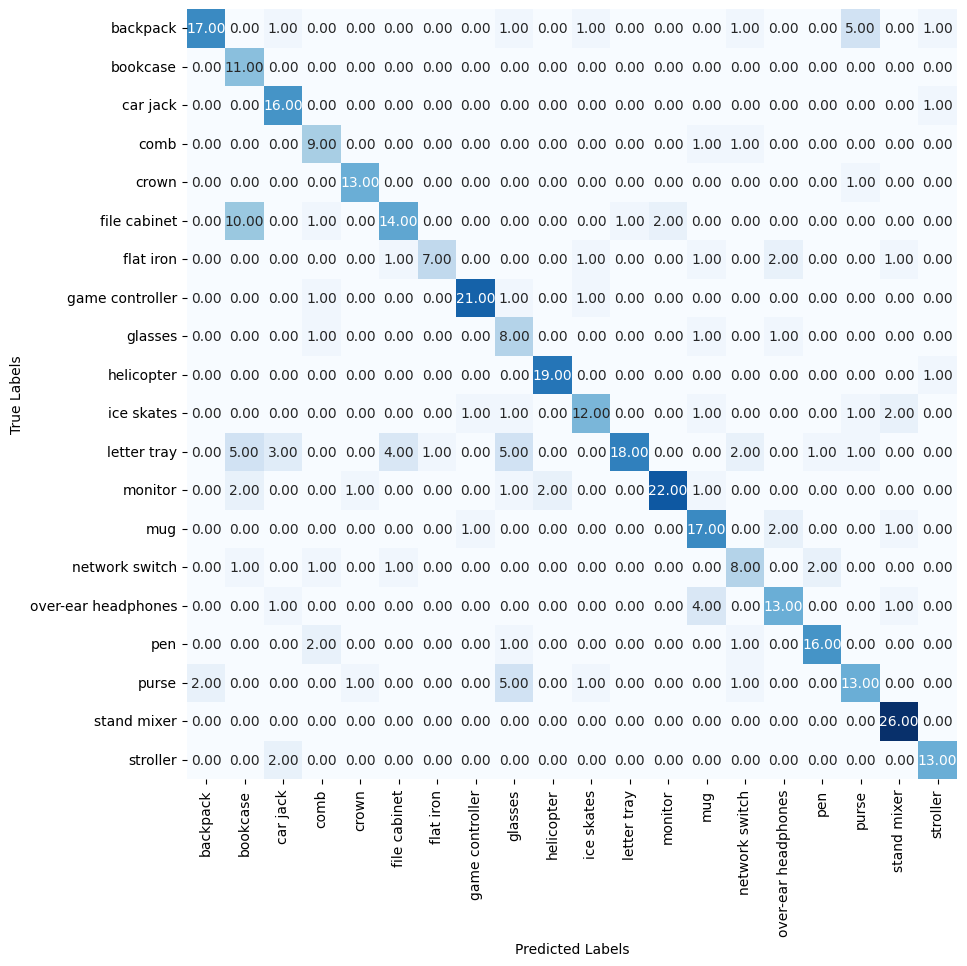

In [ ]:
plot_confusion_matrix(y_true, y_pred, classes)

**Roc Curve**

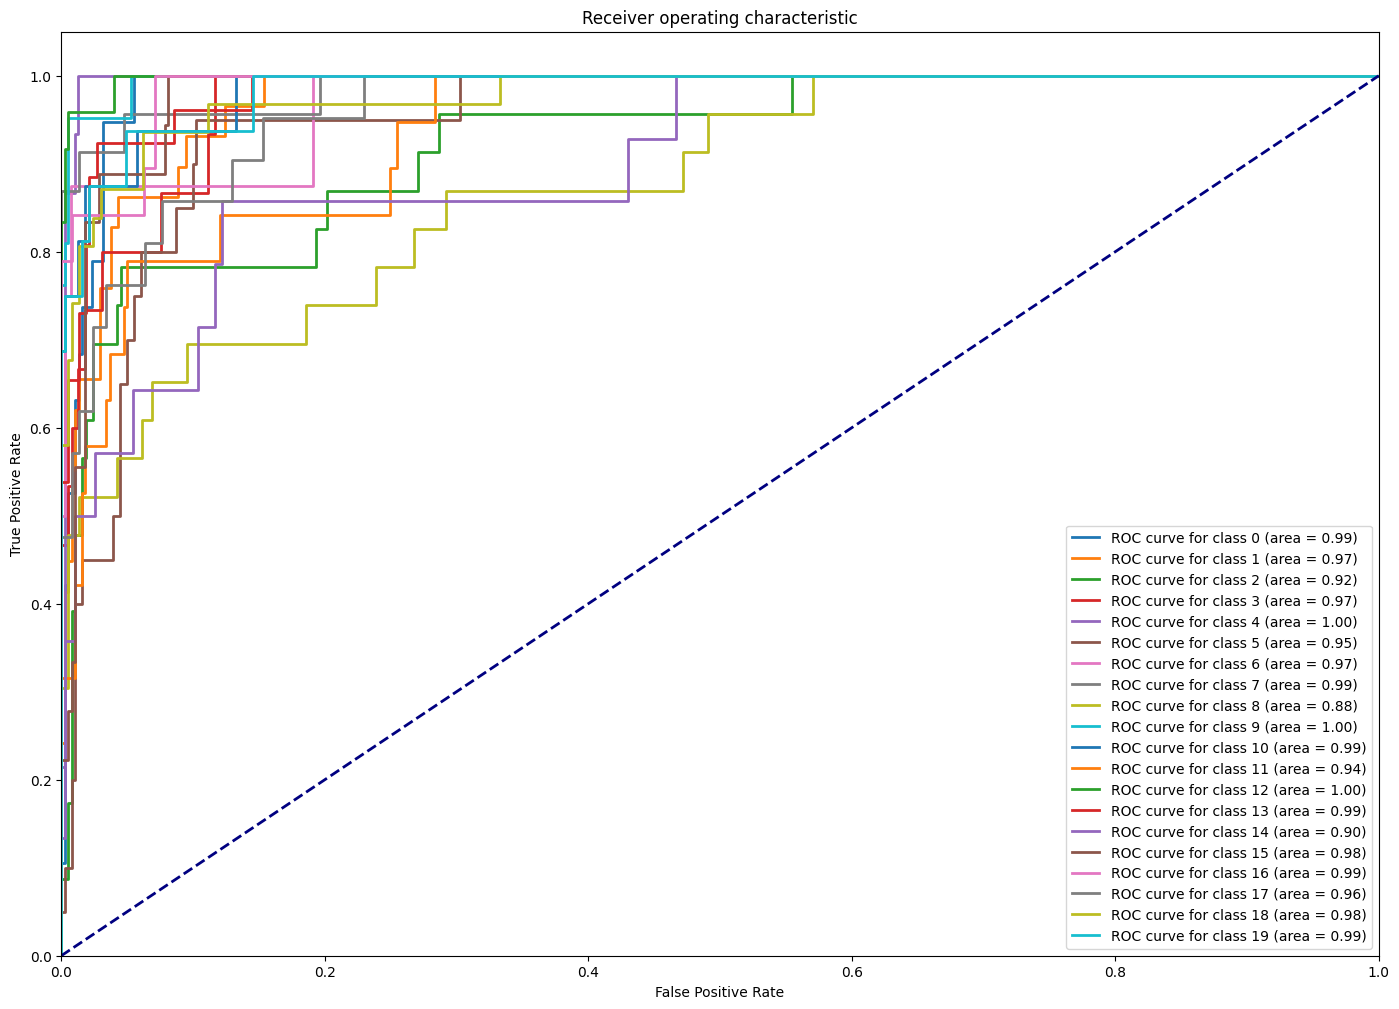

In [ ]:
plot_roc_curve(net, 'real_life')

**Predicted Labels**

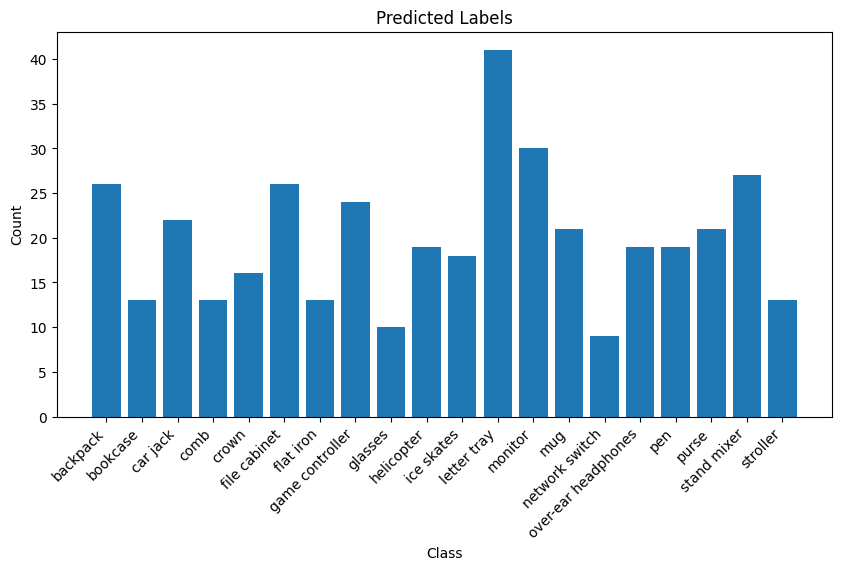

In [ ]:
plot_predicted_labels(net, 'real_life')

##### **Product $⟶$ Product**

Before training:
	 Training loss 0.04745, Training accuracy 7.75
	 Test loss 0.05351, Test accuracy 7.00
-----------------------------------------------------
Epoch: 1
	 Training loss 0.04464, Training accuracy 20.88
	 Test loss 0.04675, Test accuracy 37.50
-----------------------------------------------------
Epoch: 2
	 Training loss 0.03811, Training accuracy 60.44
	 Test loss 0.03875, Test accuracy 76.50
-----------------------------------------------------
Epoch: 3
	 Training loss 0.02984, Training accuracy 87.69
	 Test loss 0.02854, Test accuracy 88.25
-----------------------------------------------------
Epoch: 4
	 Training loss 0.02103, Training accuracy 93.75
	 Test loss 0.01929, Test accuracy 90.25
-----------------------------------------------------
Epoch: 5
	 Training loss 0.01411, Training accuracy 94.25
	 Test loss 0.01342, Test accuracy 93.25
-----------------------------------------------------
Epoch: 6
	 Training loss 0.00968, Training accuracy 95.38
	 Test loss 0.0097

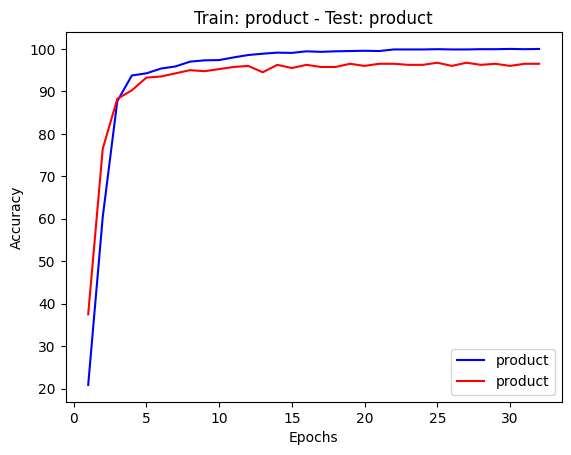

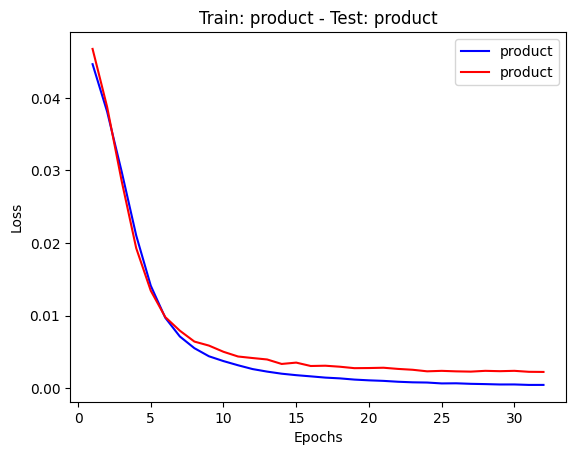

Upper bound after training on Product and test on Product is:
	 Test loss 0.00222, Test accuracy 96.50
-----------------------------------------------------


In [ ]:
# Instantiate ResNet18
net = ResNet18(len(classes)).to(device)

loss, accuracy = main(net, batch_size, 'cuda:0', learning_rate, weight_decay, momentum, chk_monotonic, fine_tuning, std_optimizer, epochs, 'product', 'product', cost_function, stop)

#print final metrics
print('Upper bound after training on Product and test on Product is:')
print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(loss, accuracy))
print('-----------------------------------------------------')

**Predictions**

In [ ]:
y_true, y_pred = predict(net, 'product', device='cuda')

**Confusion Matrix**

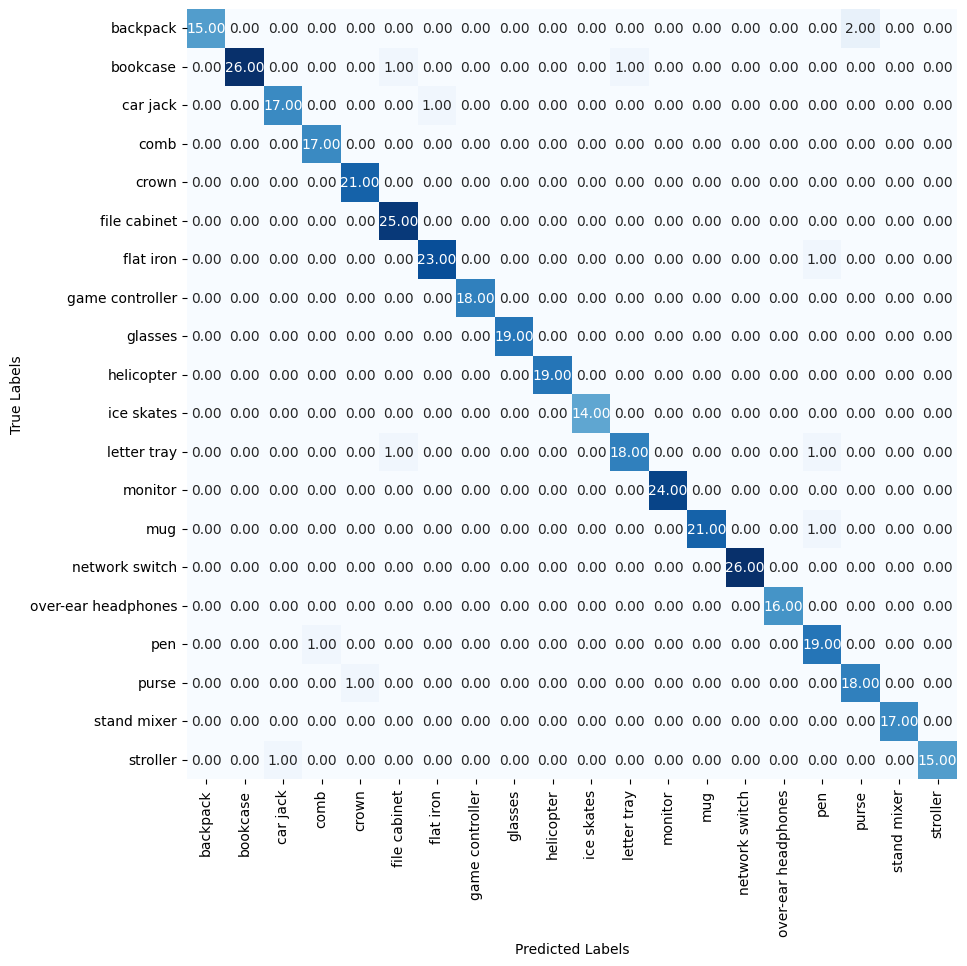

In [ ]:
plot_confusion_matrix(y_true, y_pred, classes)

**Roc Curve**

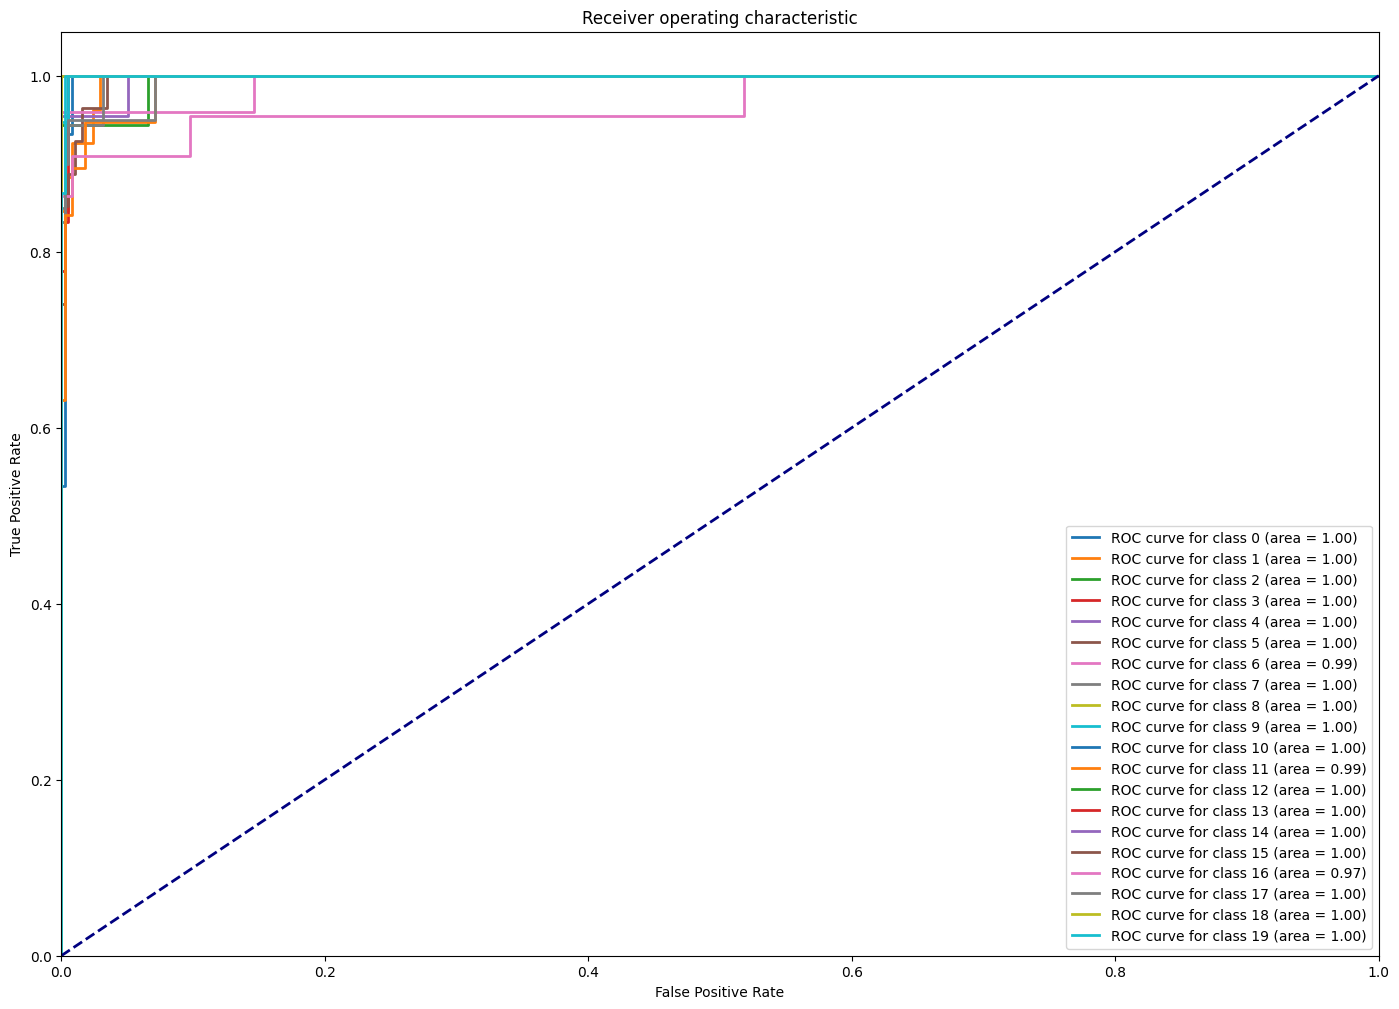

In [ ]:
plot_roc_curve(net, 'product')

**Predicted labels**

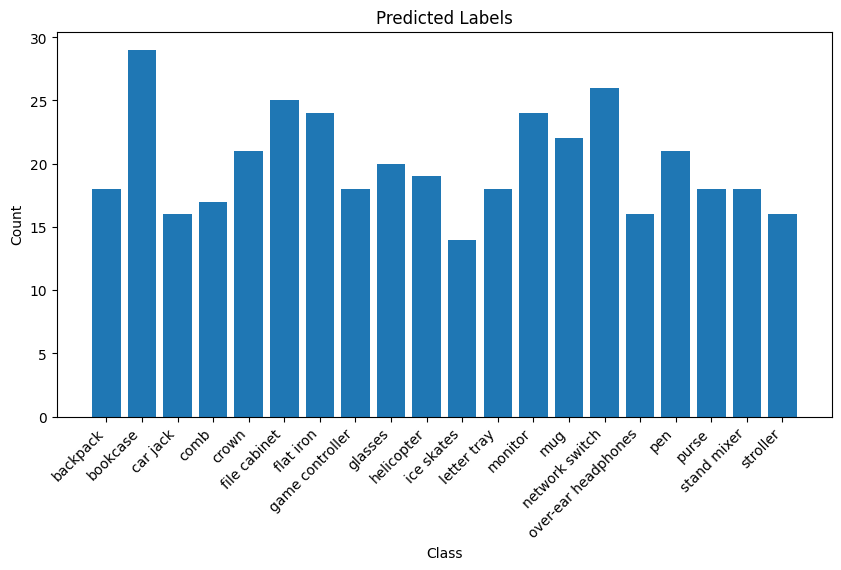

In [ ]:
plot_predicted_labels(net, 'product')

##### **Real Life $⟶$ Real Life**

Before training:
	 Training loss 0.04746, Training accuracy 3.62
	 Test loss 0.05370, Test accuracy 3.75
-----------------------------------------------------
Epoch: 1
	 Training loss 0.04573, Training accuracy 11.25
	 Test loss 0.04924, Test accuracy 18.50
-----------------------------------------------------
Epoch: 2
	 Training loss 0.04213, Training accuracy 36.31
	 Test loss 0.04499, Test accuracy 48.50
-----------------------------------------------------
Epoch: 3
	 Training loss 0.03776, Training accuracy 63.00
	 Test loss 0.03939, Test accuracy 66.50
-----------------------------------------------------
Epoch: 4
	 Training loss 0.03190, Training accuracy 77.69
	 Test loss 0.03191, Test accuracy 76.25
-----------------------------------------------------
Epoch: 5
	 Training loss 0.02547, Training accuracy 84.12
	 Test loss 0.02549, Test accuracy 80.00
-----------------------------------------------------
Epoch: 6
	 Training loss 0.01954, Training accuracy 86.94
	 Test loss 0.0198

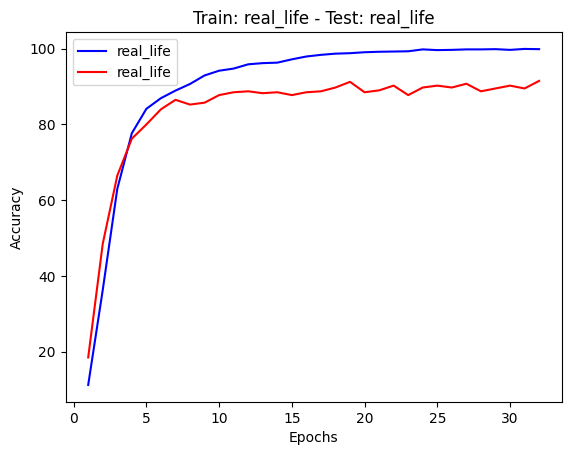

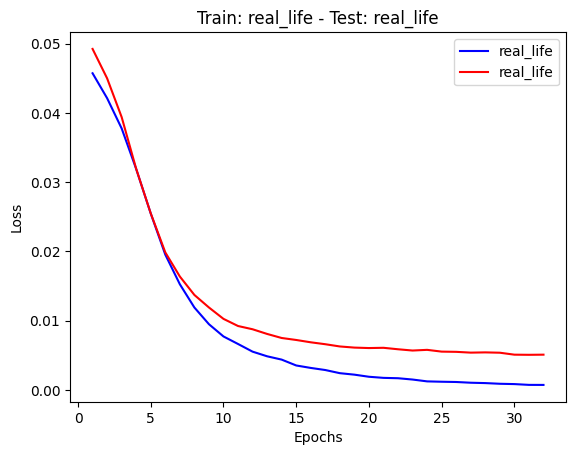

Upper bound after training on Real Life and test on Real Life is:
	 Test loss 0.00507, Test accuracy 89.50
-----------------------------------------------------


In [ ]:
# Instantiate ResNet18
net = ResNet18(len(classes)).to(device)

loss, accuracy = main(net, batch_size, 'cuda:0', learning_rate, weight_decay, momentum, chk_monotonic, fine_tuning, std_optimizer, epochs, 'real_life', 'real_life', cost_function, stop)

#print final metrics
print('Upper bound after training on Real Life and test on Real Life is:')
print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(loss, accuracy))
print('-----------------------------------------------------')

**Predictions**

In [ ]:
y_true, y_pred = predict(net, 'real_life', device='cuda')

**Confusion Matrix**

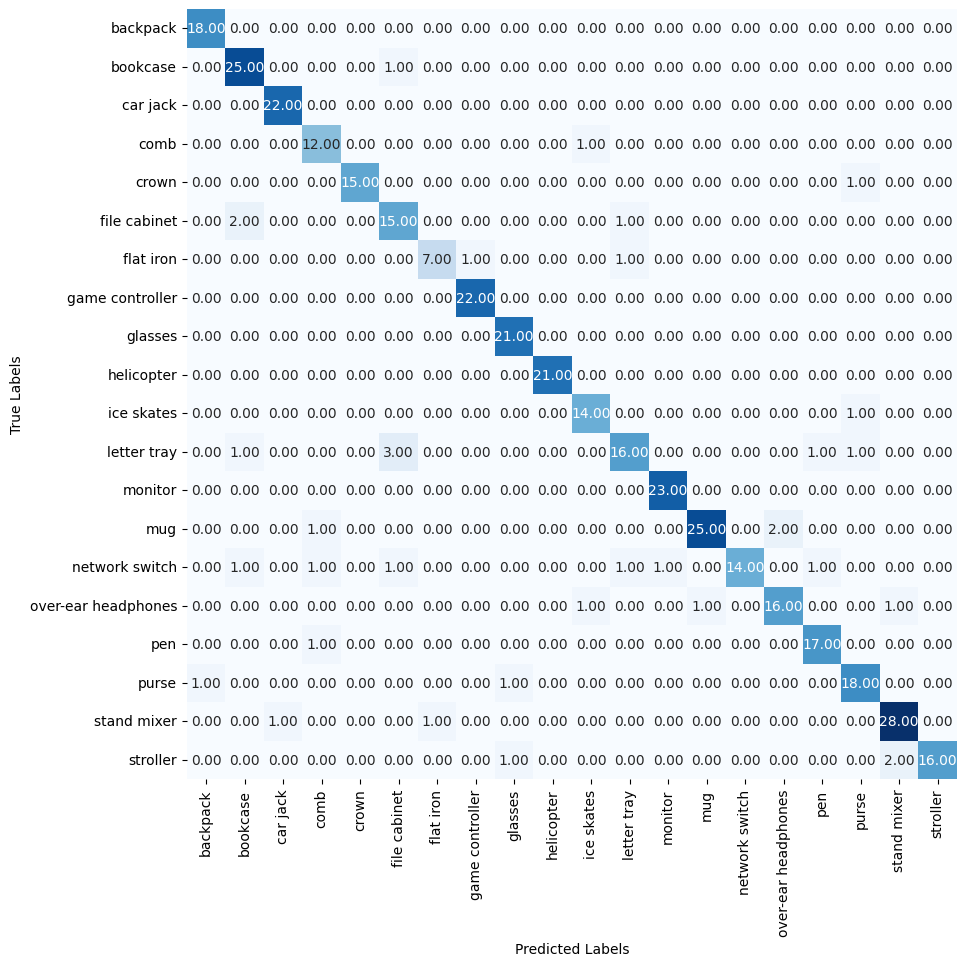

In [ ]:
plot_confusion_matrix(y_true, y_pred, classes)

**Roc Curve**

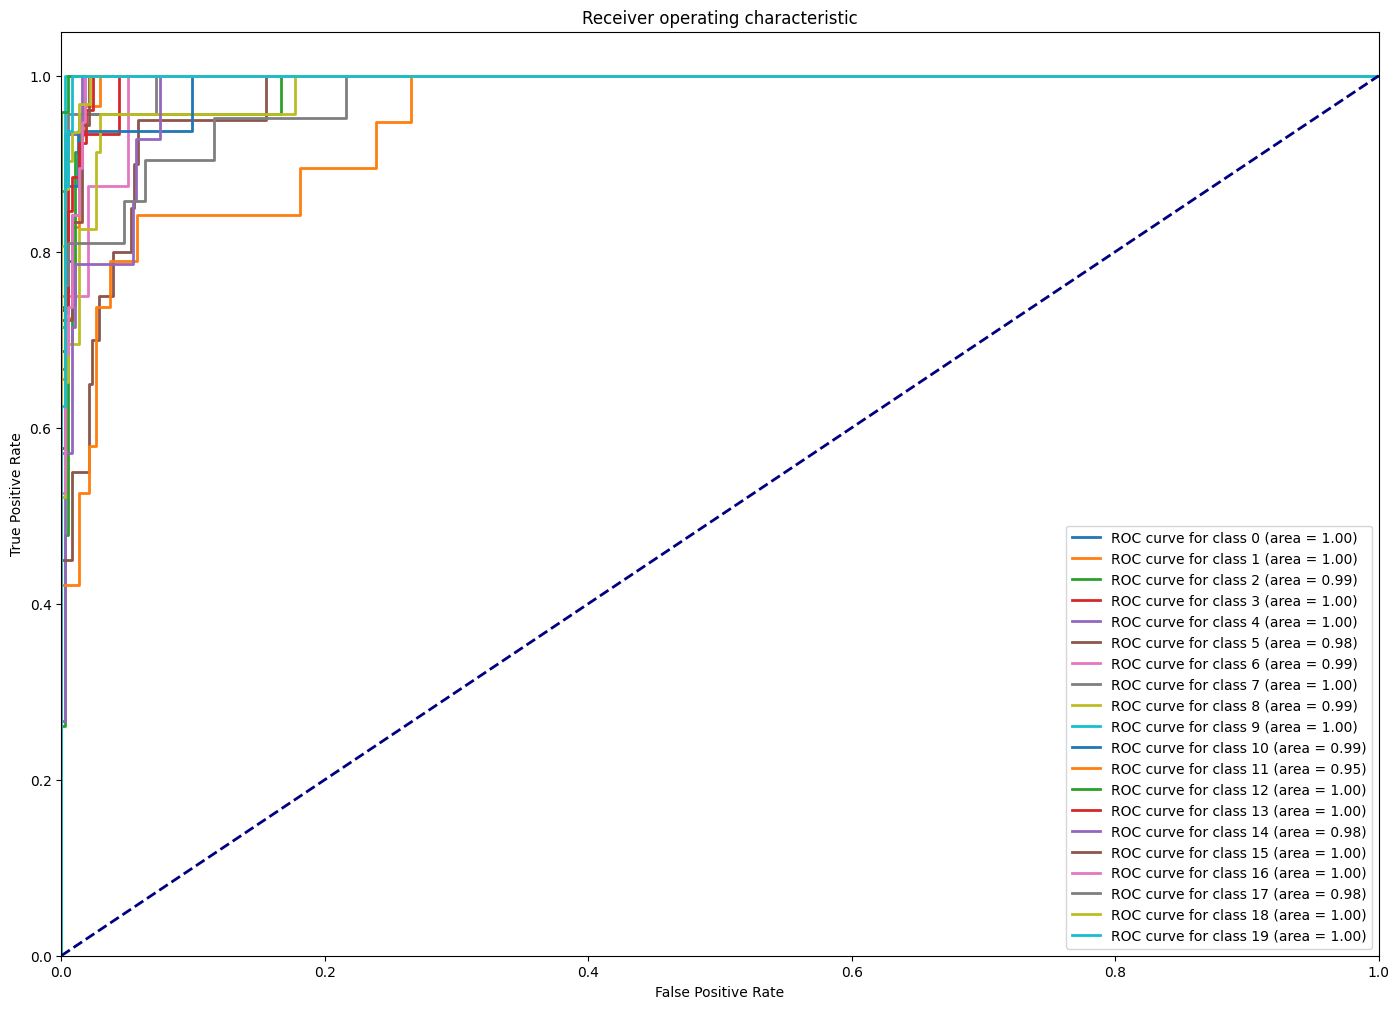

In [ ]:
plot_roc_curve(net, 'real_life')

**Predicted labels**

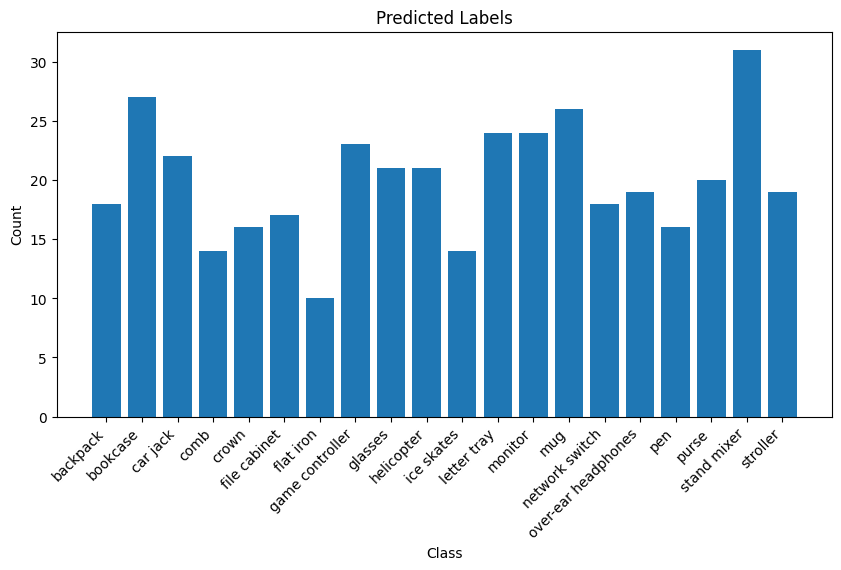

In [ ]:
plot_predicted_labels(net, 'real_life')

### **Third step**

In this step is implemented the main goal of this assignment: finding an unsupervised domain adaptation technique able to provide us with significant values of accuracies.

Three different methods have been exploited:



*  Pseudo Labels;
*  Adversarial Discriminative Domain Adaptation (ADDA);
*  Unsupervised Domain Adaptation by Backpropagation.

The first trial is a very simple technque which however allows us to achieve satisfying results.

In order to improve them we have looked through various papers and in particular we have found interesting the one related to ADDA.

Not completely satisfied of the results obtained, we have given a trial to the domain adaptation technique that proceeds with a backpropagation mechanism with a gradient reversal layer.

This method has outperformed the results previously achieved by the Pseudo Labels method.

Let's comment on them in the subsections below.




##### **Pseudo Labels**


The distribution disparity between the source and target domains poses a substantial difficulty for UDA. Pseudo-labeling, which creates labels for unlabeled target data, is a useful strategy for overcoming this problem.
By assessing both marginal and conditional distribution disparities, the majority of UDA approaches conventionally assess the distributional discrepancy. However, in UDA settings, target data does not have labels for samples, which are necessary to calculate the conditional distribution difference. To get around this, pseudo-labeling techniques are used to label the target samples and then assess the change in the conditional distribution.
Pseudo-labels have been created using either the source samples with labels or the source and target class centers in previous UDA approaches. The iterative process might become confused when these methods, which frequently have a high ratio of inaccurate target labels in the beginning rounds.

Here, a straightforward function is built that forecasts the labels on the target using the model applied to the source data. The target image is associated with the label and then the model on the resulting data if the likelihood of the prediction exceeds a predetermined threshold (0.9 in our case).

https://www.sciencedirect.com/science/article/pii/S0020025523001238?ref=pdf_download&fr=RR-2&rr=7d63e70b5eff28aa

In [ ]:
def Create_pseudo_label(source, target, epochs, stop, batch_size, threshold, device='cuda'):

    # Initialize minimum loss to a large value and set the early stopping patience.
    min_loss = 10e6
    early_stopping_patience = stop
    early_stopping = EarlyStopping(patience=early_stopping_patience)

    # Set the file paths for saving and loading the model weights.
    source_path = '/content/drive/MyDrive/deep/trained_models/best_' + source + '_' + source +'.pth'
    target_path = '/content/drive/MyDrive/deep/trained_models/pseudo_lab_' + source + '_' + target + '.pth'

    # Load the model's state_dict from Google Drive.
    state_dict = torch.load(source_path)

    # Initialize the target model (ResNet18 with 20 output classes) and load the weights.
    target_model = ResNet18(20).to(device)
    target_model.load_state_dict(state_dict)

    # Initialize the optimizer (NTASGD) for training the model.
    optimizer = NTASGD(target_model.parameters(), learning_rate, chk_monotonic, weight_decay, fine_tuning)

    # Load the target dataset using DataLoader.
    target_loader = DataLoader(globals()[target + '_train_dataset'], batch_size=batch_size, shuffle=False, drop_last=True, num_workers=1, pin_memory=True)

    # Phase 2: Use the model to make predictions on the target dataset and create new labels.
    # Start generating pseudo-labels.
    target_labels = []
    target_inputs = []
    target_model.eval()   # Set the model in evaluation mode.
    with torch.no_grad(): # Do not compute gradients since we are only forward passing.
        # Iterate through the batches of data in target_loader.
        for i, target_data in enumerate(target_loader, 0):
            inputs, _ = target_data
            inputs = inputs.to(device)

            # Pass the inputs through the model and perform softmax to get probabilities.
            outputs = torch.softmax(target_model(inputs), dim=1)

            # Select predictions that have confidence greater than a threshold.
            probs, preds = torch.max(outputs, dim=1)
            mask = probs > threshold

            # Extend the target_inputs and target_labels lists.
            target_inputs.extend(inputs[mask].cpu())
            target_labels.extend(preds[mask].cpu())

    # Phase 3: Train the model on the target dataset with the new labels.
    # Loop through each epoch.
    for epoch in range(1, epochs+1):
        running_loss = 0.0

        # Check if there are target labels.
        if target_labels:

            # Set the model in training mode.
            target_model.train()
            # Loop through the batches of data.
            for j in range(0, len(target_inputs), batch_size):
                batch_inputs = torch.stack(target_inputs[j:j+batch_size]).to(device)
                batch_labels = torch.stack(target_labels[j:j+batch_size]).to(device)

                # Zero the gradients.
                optimizer.zero_grad()
                # Forward pass.
                outputs = target_model(batch_inputs)
                # Compute the loss.
                loss = cost_function(outputs, batch_labels)
                # Backward pass.
                loss.backward()

                # Update the weights.
                for p in optimizer.param_groups[0]['params']:
                    if p.grad is not None:
                        p.data.add_(-optimizer.param_groups[0]['lr'], p.grad.data)

                # Accumulate the loss.
                running_loss += loss.item()

        # Save the model if the loss has decreased.
        if running_loss < min_loss:
            torch.save(target_model.state_dict(), target_path)
            min_loss = running_loss
        # Print the epoch and loss.
        print('Epoch: {}, Loss: {}'.format(epoch, running_loss))

        # Check for early stopping.
        if early_stopping.step(running_loss):
            print("Early stopping triggered")
            break

    print('Finished Training on Target Dataset')
    # Load the best model.
    state_dict = torch.load(target_path)
    target_model = ResNet18(20).to(device)
    target_model.load_state_dict(state_dict)

    # Return the trained model.
    return target_model

In [ ]:
def Evaluate_accuracy(net, target, batch_size, device='cuda'):

    # Load the test dataset using DataLoader.
    test_loader = DataLoader(globals()[target + '_test_dataset'], batch_size=batch_size, shuffle=False, drop_last=True, num_workers=1, pin_memory=True)

    # Switch the network to evaluation mode. This is essential for layers like dropout and batch norm
    # which behave differently during training and evaluation.
    net.eval()

    # Initialize counters for the number of correct predictions and the total number of images.
    correct = 0
    total = 0

    # Ensure that the computation graph is not built (saving memory and computation) since we won't
    # be doing any backpropagation.
    with torch.no_grad():
        # Loop through the batches of images and labels from the test dataset.
        for images, labels in test_loader:
            # Move the images and labels to the device (GPU) where the model is.
            images, labels = images.to(device), labels.to(device)
            # Forward pass: compute the outputs by passing the images through the network.
            outputs = net(images)
            # Obtain the class predictions by finding the index of the maximum output value.
            _, predicted = torch.max(outputs.data, 1)
            # Update the total number of images processed.
            total += labels.size(0)
            # Update the number of correct predictions by summing up the correctly predicted samples.
            correct += (predicted == labels).sum().item()

    # Calculate the accuracy as the ratio of correct predictions to the total number of
    accuracy = correct / total

    # Print the accuracy of the network on the test dataset.
    print('Accuracy of the network on the ' + target + ' test images: %d %%' % (100 * accuracy))

###### **Real2Prod**

In [ ]:
target_model = Create_pseudo_label('real_life', 'product', epochs, stop, batch_size, threshold)
Evaluate_accuracy(target_model, 'product', batch_size)

Epoch: 1, Loss: 0.8674584738910198
Epoch: 2, Loss: 0.5563470628112555
Epoch: 3, Loss: 0.45388040877878666
Epoch: 4, Loss: 0.3907009921967983
Epoch: 5, Loss: 0.34601543098688126
Epoch: 6, Loss: 0.312049413099885
Epoch: 7, Loss: 0.28495357278734446
Epoch: 8, Loss: 0.2628055578097701
Epoch: 9, Loss: 0.244247374124825
Epoch: 10, Loss: 0.2284021181985736
Epoch: 11, Loss: 0.21468180790543556
Epoch: 12, Loss: 0.20264098793268204
Epoch: 13, Loss: 0.19198084250092506
Epoch: 14, Loss: 0.18247757013887167
Epoch: 15, Loss: 0.17393052112311125
Epoch: 16, Loss: 0.16619733907282352
Epoch: 17, Loss: 0.15915901912376285
Epoch: 18, Loss: 0.15272968728095293
Epoch: 19, Loss: 0.14683155342936516
Epoch: 20, Loss: 0.14139511715620756
Epoch: 21, Loss: 0.1363627426326275
Epoch: 22, Loss: 0.13169491989538074
Epoch: 23, Loss: 0.12735025119036436
Epoch: 24, Loss: 0.12329535651952028
Epoch: 25, Loss: 0.11950079072266817
Epoch: 26, Loss: 0.11594090797007084
Epoch: 27, Loss: 0.11259560799226165
Epoch: 28, Loss: 0.1

In [ ]:
y_true, y_pred = predict(target_model, 'product', device='cuda')

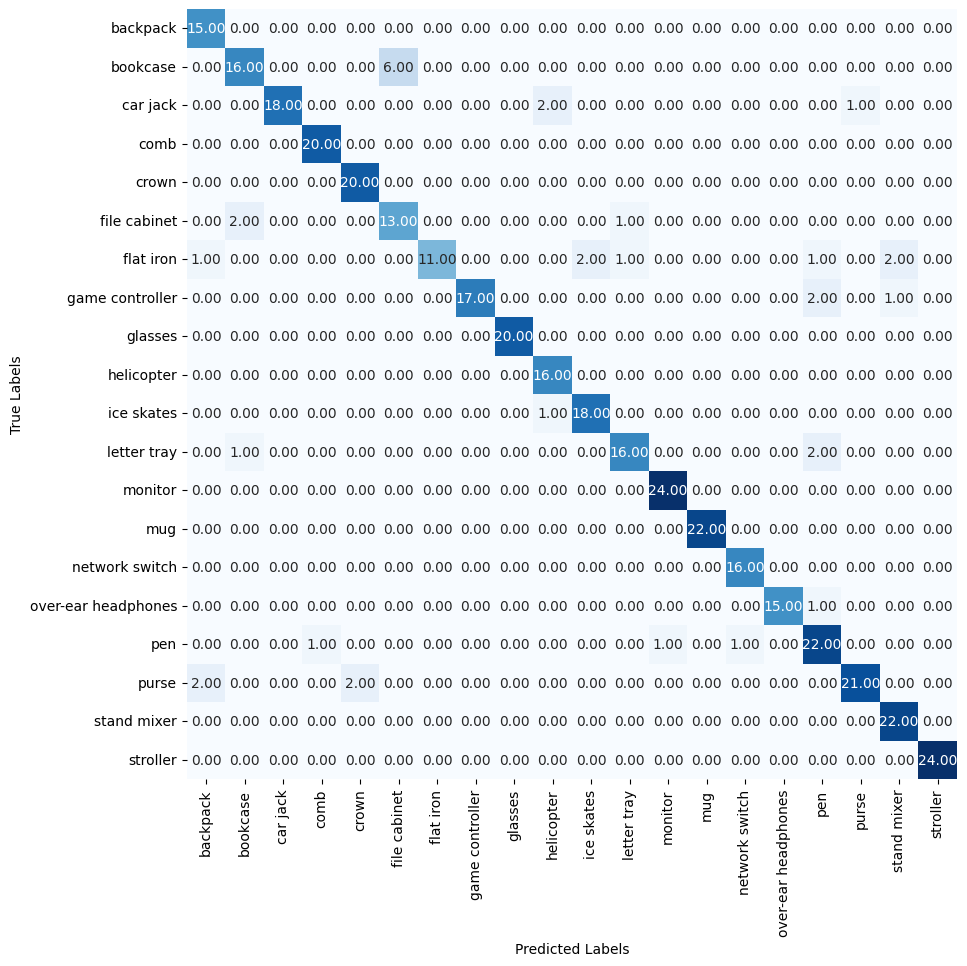

In [ ]:
plot_confusion_matrix(y_true, y_pred, classes)

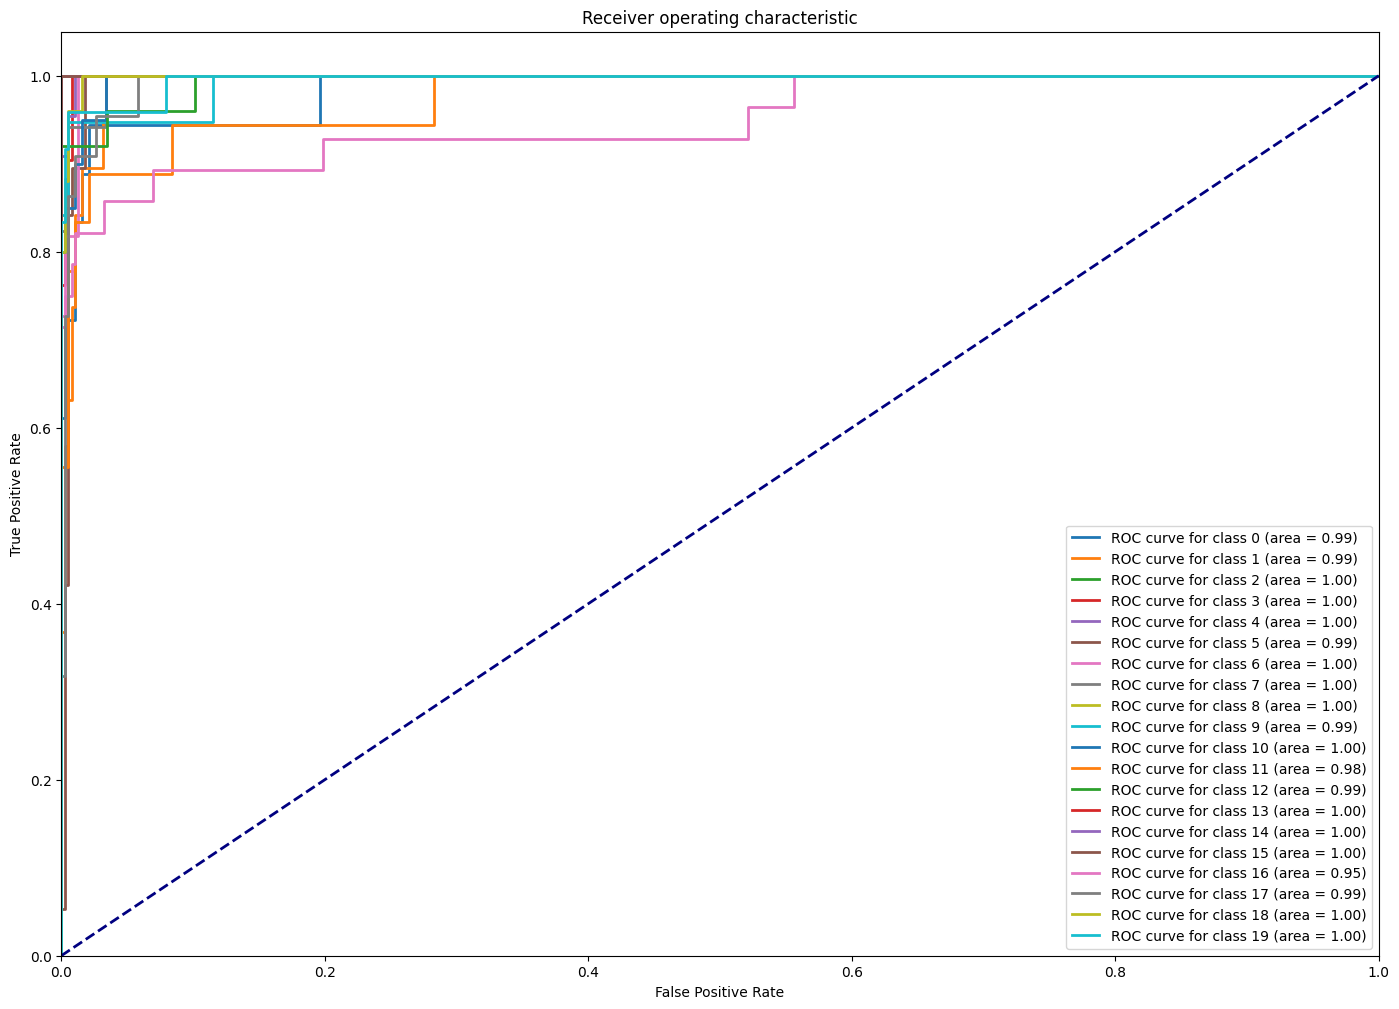

In [ ]:
plot_roc_curve(target_model, 'product')

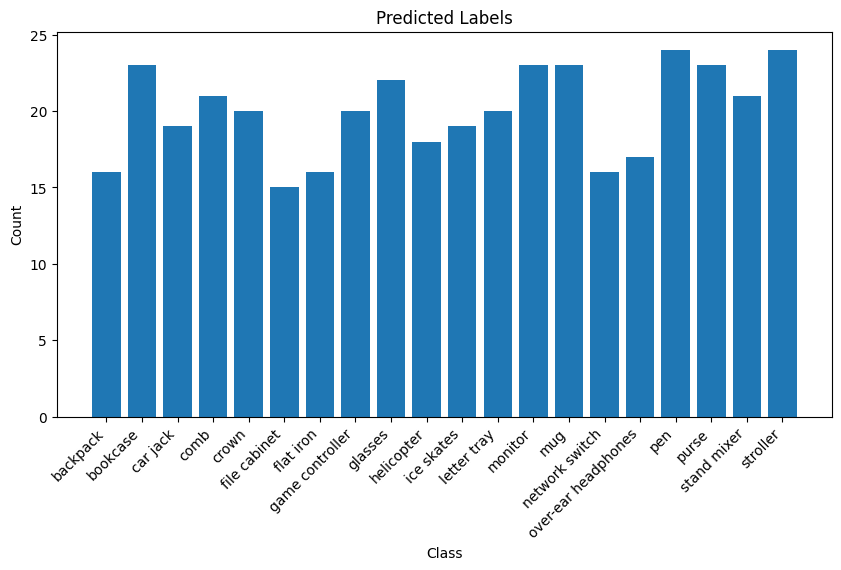

In [ ]:
plot_predicted_labels(target_model, 'product')

###### **Prod2Real**

In [ ]:
target_model = Create_pseudo_label('product', 'real_life',epochs , stop, batch_size, threshold)
Evaluate_accuracy(target_model, 'real_life', batch_size)

Epoch: 1, Loss: 0.5959208346903324
Epoch: 2, Loss: 0.40115050226449966
Epoch: 3, Loss: 0.33238401636481285
Epoch: 4, Loss: 0.2911401465535164
Epoch: 5, Loss: 0.26198859326541424
Epoch: 6, Loss: 0.2396276742219925
Epoch: 7, Loss: 0.22167332842946053
Epoch: 8, Loss: 0.2067478634417057
Epoch: 9, Loss: 0.19406991079449654
Epoch: 10, Loss: 0.18310917355120182
Epoch: 11, Loss: 0.1734989769756794
Epoch: 12, Loss: 0.16497247479856014
Epoch: 13, Loss: 0.1573357731103897
Epoch: 14, Loss: 0.1504485160112381
Epoch: 15, Loss: 0.14419925585389137
Epoch: 16, Loss: 0.13849605806171894
Epoch: 17, Loss: 0.13326210249215364
Epoch: 18, Loss: 0.12843663338571787
Epoch: 19, Loss: 0.12397203501313925
Epoch: 20, Loss: 0.11982642114162445
Epoch: 21, Loss: 0.11596351210027933
Epoch: 22, Loss: 0.11235211230814457
Epoch: 23, Loss: 0.10896921809762716
Epoch: 24, Loss: 0.10579514224082232
Epoch: 25, Loss: 0.10280990228056908
Epoch: 26, Loss: 0.09999662172049284
Epoch: 27, Loss: 0.09733935352414846
Epoch: 28, Loss: 

In [ ]:
y_true, y_pred = predict(target_model, 'real_life', device='cuda')

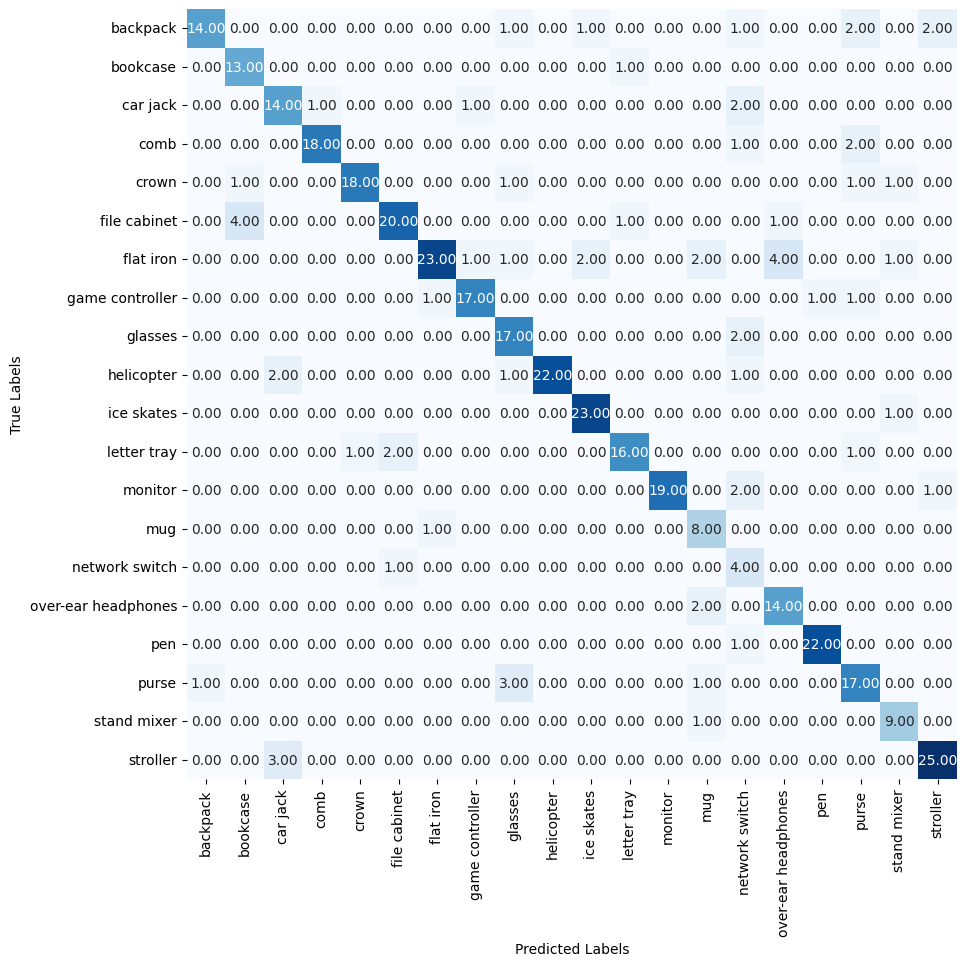

In [ ]:
plot_confusion_matrix(y_true, y_pred, classes)

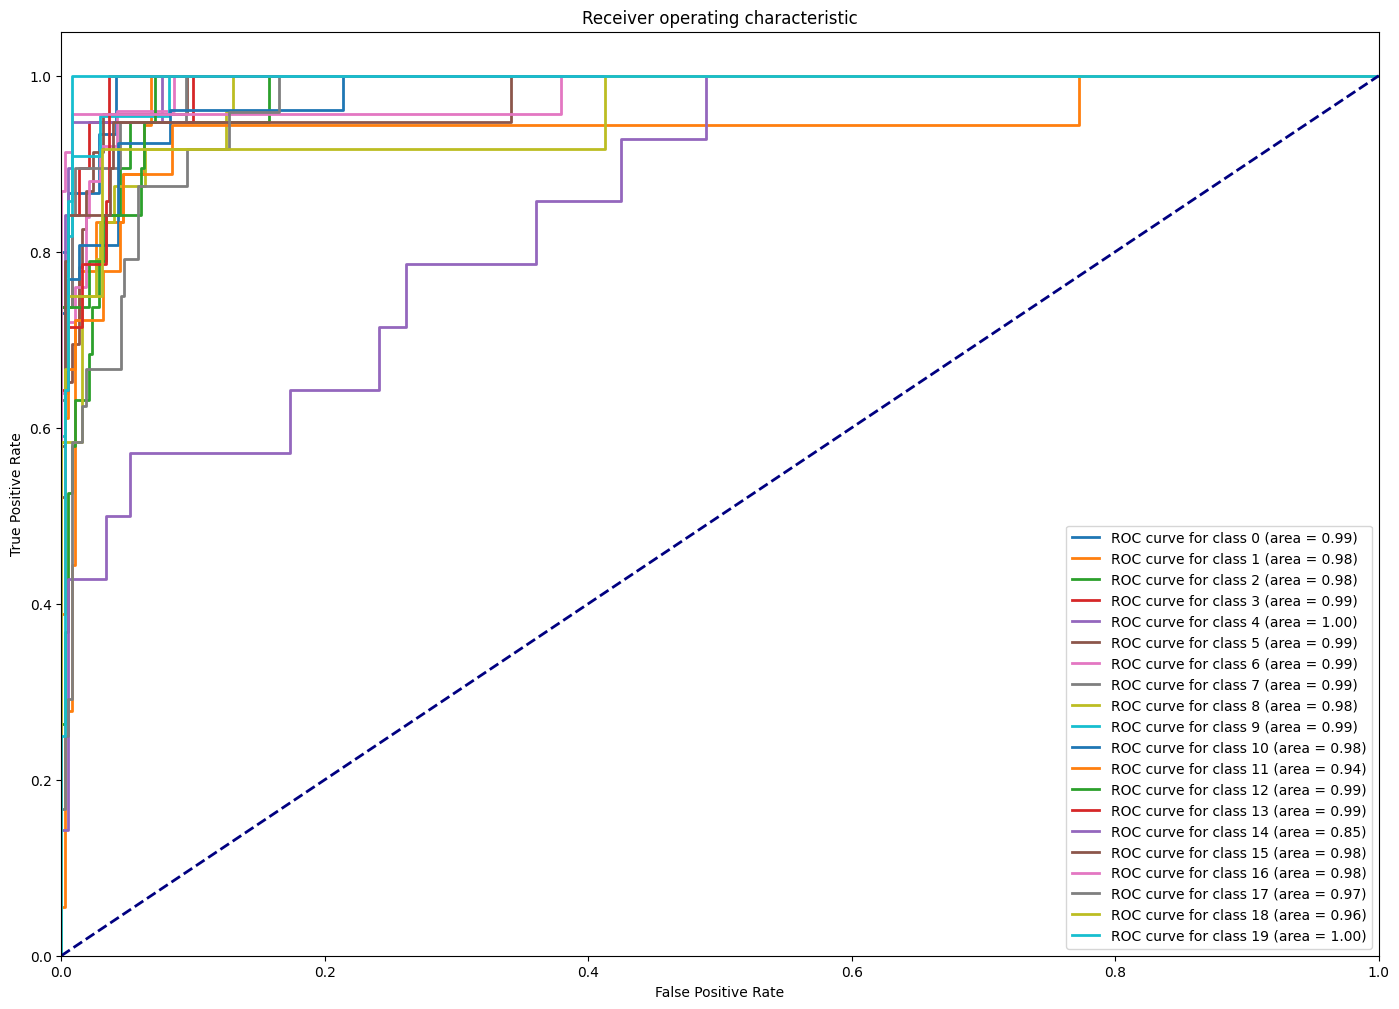

In [ ]:
plot_roc_curve(target_model, 'real_life')

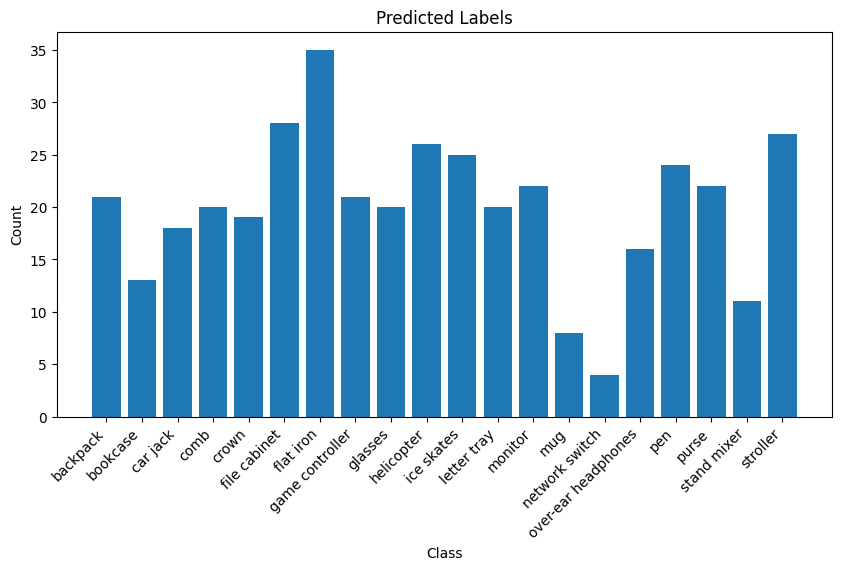

In [ ]:
plot_predicted_labels(target_model, 'real_life')

#### **Adversarial Discriminative Domain Adaptation (ADDA)**

https://github.com/jvanvugt/pytorch-domain-adaptation/blob/master/adda.py

In order to decrease the detrimental effects of domain shift, domain adaption techniques have been proposed as a possible remedy. All of these techniques share the goal of learning deep neural transformations that can map both domains into a single feature space through representational optimization. This minimizes particular domain shift measurements.

One of the major problems in unsupervised domain adaptation is to minimize the distance between the source and target domains while still guaranteeing that the adapted model can perform well on a task specific to the target domain.

Adversarial adaptation is a popular method that uses an adversarial objective with respect to a domain discriminator.

In particular, this strategy operates by competing between a generator network and a discriminator network. The generator produces images that are trained to confound the discriminator, which attempts to distinguish the images from samples of genuine photos. To ensure that the network cannot differentiate between the distributions of its training domain samples and its test domain samples.

Weight sharing, base models, and adversarial losses are among the design components included in the project's specialized architecture for adversarial domain adaptation. Additionally, it makes it easier to build new instantiations that improve on existing ones.

It is named ADDA, e.g., Adversarial Discriminative Domain Adaptation.

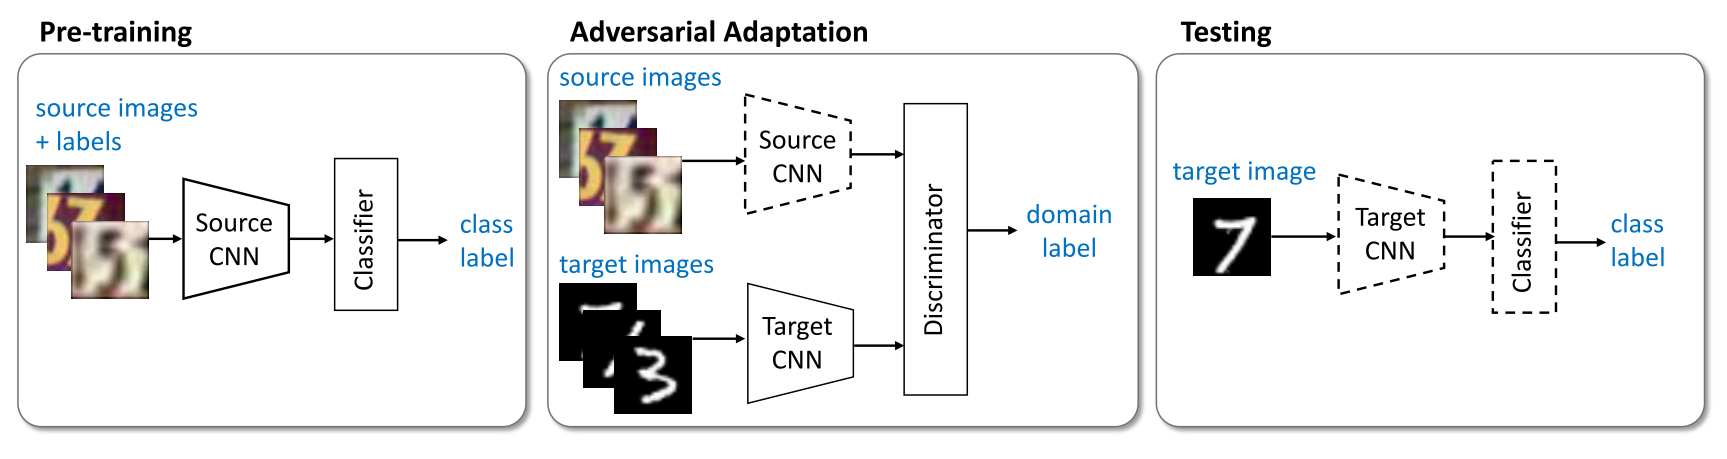

The basic principle of ADDA is an asymmetric mapping that uses labels from the source domain and encodes the target domain into the same feature space to learn a discriminative representation. Asymmetric mapping stands out because it can accurately reflect differences in low-level properties, which is essential for domain adaptation. ADDA aims to reduce the distributional divergence between the source and target domains through domain-adversarial loss.

Aiming to train a classifier $C_t$ that can accurately classify target images into one of the $K$ categories without the need for target labels, ADDA takes into account $X_S$ as source images with corresponding labels $Y_S$ drawn from a source domain distribution $p_s(x, y)$ and $X_T$ as target images from a target distribution $p_t(x, y)$.

ADDA eliminates the necessity for a separate target classifier by minimizing the discrepancy between the source and target mapping distributions, $M_s(X_s)$ and $M_t(X_t)$, using a limited adversarial objective.

The source classification model $C_s$ can be applied directly to the target representations using the traditional supervised loss if the classifier $C$ is configured as $C = C_s = C_t$.

Setting up parameterized mappings for both the source and target domains is the first step.

Different regularization strategies have been presented to make sure the target mapping minimizes the distance between the source and target domains while maintaining discriminative features.

Source and target layer-wise equality is a frequent restriction that enables independent restrictions on each layer. This can either impose full alignment by limiting all levels, or it can enforce partial alignment by constraining only a selection of layers. To enable models to learn domain-specific parameters, modern approaches have tended to decouple the weights for the two domains.

In order to learn the mapping after determining the target mapping parameterization, ADDA uses the standard Generative Adversarial Network (GAN) loss. The adversarial discriminator is typically trained using a regular classification loss in adversarial losses, but what makes them unique is how the loss is applied to train the mapping. It is improved to maximize the discriminator's loss using a gradient reversal layer. This is consistent with the genuine minimax objective, which can occasionally provide difficulties due to the discriminator's quick convergence, resulting in vanishing gradients.

However, using the standard loss function with inverted labels aims to give the target mapping stable gradients.

In order to properly learn an asymmetric mapping, ADDA uses the previously trained source model as an initialization for the target representation space and maintains the source model fixed during adversarial training.

Utiliy functions required for the ADDA implementation:

In [ ]:
def set_requires_grad(model, requires_grad=True):
    """
    Set the requires_grad attribute of each parameter in the model.

    :param model: The model whose parameters' requires_grad will be set.
    :type model: torch.nn.Module
    :param requires_grad: Flag indicating whether the gradients should be computed, defaults to True.
    :type requires_grad: bool
    """

    # Iterate through each parameter in the model
    for param in model.parameters():
        # Set the requires_grad attribute of the parameter
        param.requires_grad = requires_grad


def loop_iterable(iterable):
    """
    An infinite generator that continuously loops through an iterable.

    :param iterable: The iterable to loop through.
    :type iterable: iterable
    """

    # Infinite loop
    while True:
        # Yield elements from the input iterable
        yield from iterable



In [ ]:
def test_adda(target_model, target, device):

    # Set the model to evaluation mode
    target_model.eval()

    # Create data loader for target data
    target_loader = DataLoader(globals()[target + '_test_dataset'], batch_size=batch_size, shuffle=False, num_workers=1, pin_memory=True)


    # Initialize counters for the number of correct predictions and the total number of images.
    correct = 0
    total = 0


    # Ensure that the computation graph is not built (saving memory and computation) since we won't
    # be doing any backpropagation.
    with torch.no_grad():
        for data in target_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = target_model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total

    print("Test accuracy: {:.2f}%".format(accuracy))

ADDA

In [ ]:
def Adda(pathModel, batch_size, iterations, epochs, source, target, k_disc, k_clf, device):

    target_path = '/content/drive/MyDrive/deep/trained_models/adda_' + source + '_' + target + '.pth'

    # Initialize minimum loss to a large value
    min_loss = 10e6

    # Load the model's state_dict from Google Drive.
    state_dict = torch.load(pathModel)

    # Initialize the target model (ResNet18 with 20 output classes) and load the weights.
    model = ResNet18(20).to(device)
    model.load_state_dict(state_dict)

    # load params
    # source model
    source_model = ResNet18(20).to(device)
    source_model.load_state_dict(state_dict)
    source_model.eval()
    set_requires_grad(source_model, requires_grad=False)

    clf = source_model
    source_model = source_model.feature_extractor

    #target model
    target_model = ResNet18(20).to(device)
    target_model.load_state_dict(state_dict)
    target_model = target_model.feature_extractor


    #define the discriminator with a GradientReversal layer,
    # a linear layer with 512 input features and 64 output features,
    #a ReLU activation function, another linear layer with 128 input features and 20 output features,
    # another ReLU activation function, and a linear layer with 20 input features and 1 output feature

    discriminator = nn.Sequential(
        nn.Linear(512, 128),
        nn.ReLU(),
        nn.Linear(128, 20),
        nn.ReLU(),
        nn.Linear(20, 1)
    ).to(device)

    half_batch = batch_size // 2

    # Create data loaders for the source and target domains
    source_loader = DataLoader(globals()[source + '_train_dataset'], batch_size=half_batch, shuffle=True, drop_last=True, num_workers=1, pin_memory=True)
    target_loader = DataLoader(globals()[target + '_train_dataset'], batch_size=half_batch, shuffle=True, drop_last=True, num_workers=1, pin_memory=True)


    # Define optimizers and criterion
    discriminator_optim = torch.optim.Adam(discriminator.parameters())
    target_optim = torch.optim.Adam(target_model.parameters())
    criterion = nn.BCEWithLogitsLoss()

    for epoch in range(1, epochs+1):

        # Create an infinite iterator over the source and target data loaders
        batch_iterator = zip(loop_iterable(source_loader), loop_iterable(target_loader))

        # Initialize loss and accuracy
        total_loss = 0
        total_accuracy = 0

        running_loss = 0.
        cumulative_accuracy = 0.
        total_samples = 0

        for _ in trange(iterations, leave=False):

            set_requires_grad(target_model, requires_grad=False)
            set_requires_grad(discriminator, requires_grad=True)

            # Loop over data for k_disc steps
            for _ in range(k_disc):
                # Get next batch of data from source and target domain
                (source_x, _), (target_x, _) = next(batch_iterator)
                # Move data to the specified device (GPU in our case)
                source_x, target_x = source_x.to(device), target_x.to(device)

                # Extract features from source and target data using their respective models
                source_features = source_model(source_x).view(source_x.shape[0], -1)
                target_features = target_model(target_x).view(target_x.shape[0], -1)

                # Concatenate features for input to the discriminator
                discriminator_x = torch.cat([source_features, target_features], dim=0)
                # Create labels for the discriminator (1 for source, 0 for target)
                discriminator_y = torch.cat([torch.ones(source_x.shape[0], device=device),
                                             torch.zeros(target_x.shape[0], device=device)])

                # Forward pass through the discriminator
                preds = discriminator(discriminator_x).squeeze()
                # Compute the loss
                loss = criterion(preds, discriminator_y)

                # Zero the gradients, perform backpropagation, and update the weights
                discriminator_optim.zero_grad()
                loss.backward()
                discriminator_optim.step()

                # Update the loss and accuracy
                total_loss += loss.item()
                total_accuracy += ((preds > 0).long() == discriminator_y.long())

                running_loss += loss.item() * discriminator_x.size(0)
                predicted = (preds >= 0.5).long().cpu()
                cumulative_accuracy += (predicted == discriminator_y.long().cpu()).sum().item()
                total_samples += discriminator_x.size(0)

        # Save the model if the loss has decreased.
        if running_loss < min_loss:
            clf.feature_extractor = target_model
            torch.save(clf.state_dict(), target_path)
            min_loss = running_loss

        average_loss = running_loss / total_samples
        average_accuracy = cumulative_accuracy / total_samples * 100

        print ("AVERAGE LOSS", average_loss)
        print ("AVERAGE ACCURACY", average_accuracy)

    print('____________________________')

    print("final average loss: ", average_loss)
    print("final average accuracy: ", average_accuracy)

    return clf

Prod2Real

In [ ]:
pathModel = "/content/drive/MyDrive/deep/trained_models/best_product_real_life.pth"
adda_prod_real = Adda(pathModel, batch_size, 500, 5, 'product', 'real_life', 1, 10, device)

  5%|▍         | 24/500 [00:44<13:13,  1.67s/it]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd1fe5be0e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
  5%|▌         | 25/500 [00:47<16:01,  2.02s/it]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd1fe5be0e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/u

AVERAGE LOSS 0.19111319793388248
AVERAGE ACCURACY 90.49062500000001


AVERAGE LOSS 0.03761944202054292
AVERAGE ACCURACY 98.67812500000001


AVERAGE LOSS 0.029772507628425957
AVERAGE ACCURACY 98.909375


AVERAGE LOSS 0.01638677405336057
AVERAGE ACCURACY 99.41875


AVERAGE LOSS 0.0216846343621728
AVERAGE ACCURACY 99.146875
____________________________
final average loss:  0.0216846343621728
final average accuracy:  99.146875


In [ ]:
# Testing
test_adda(adda_prod_real, 'real_life', device)

Test accuracy: 84.00%


In [ ]:
y_true, y_pred = predict(adda_prod_real, 'real_life', device='cuda')

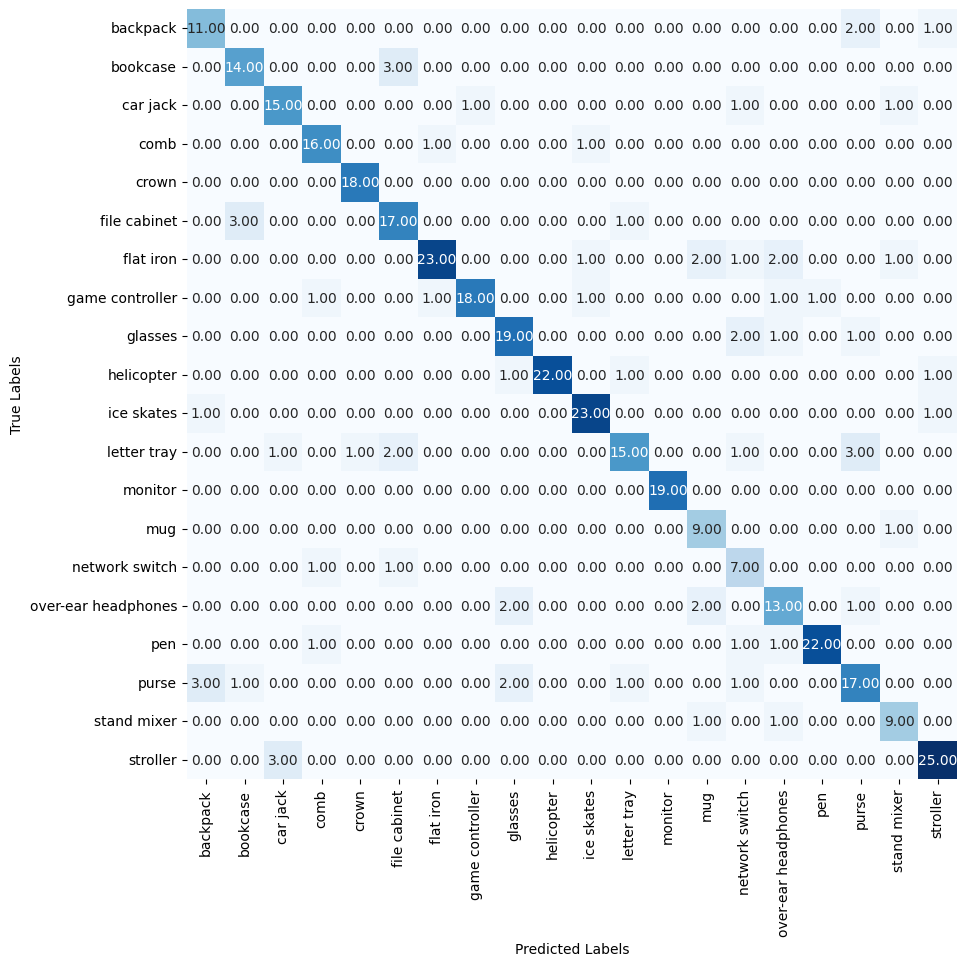

In [ ]:
plot_confusion_matrix(y_true, y_pred, classes)

In [ ]:
plot_roc_curve(adda_prod_real, 'real_life')

In [ ]:
plot_predicted_labels(adda_prod_real, 'real_life')

Real2Prod

In [ ]:
pathModel = "/content/drive/MyDrive/deep/trained_models/best_real_life_product.pth"
adda_real_prod = Adda(pathModel, batch_size, 500, 5, 'real_life', 'product', 1, 10, device)

AVERAGE LOSS 0.34977272266149523
AVERAGE ACCURACY 81.015625


AVERAGE LOSS 0.10722472963482141
AVERAGE ACCURACY 95.60625


AVERAGE LOSS 0.059419960249215364
AVERAGE ACCURACY 97.74374999999999


AVERAGE LOSS 0.050406570794992146
AVERAGE ACCURACY 98.08125


AVERAGE LOSS 0.039144983687903735
AVERAGE ACCURACY 98.50625
____________________________
final average loss:  0.039144983687903735
final average accuracy:  98.50625


In [ ]:
# Testing
test_adda(adda_real_prod, 'product', device)

Test accuracy: 91.75%


In [ ]:
y_true, y_pred = predict(adda_real_prod, 'product', device='cuda')

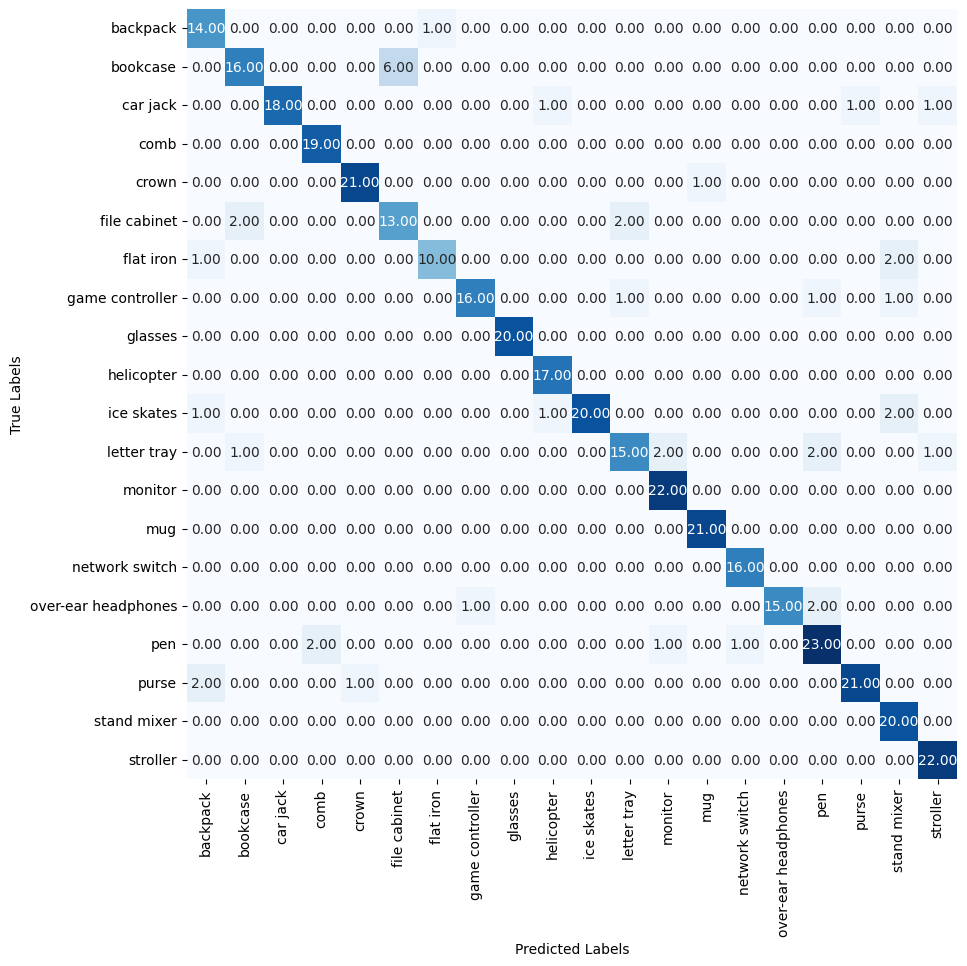

In [ ]:
plot_confusion_matrix(y_true, y_pred, classes)

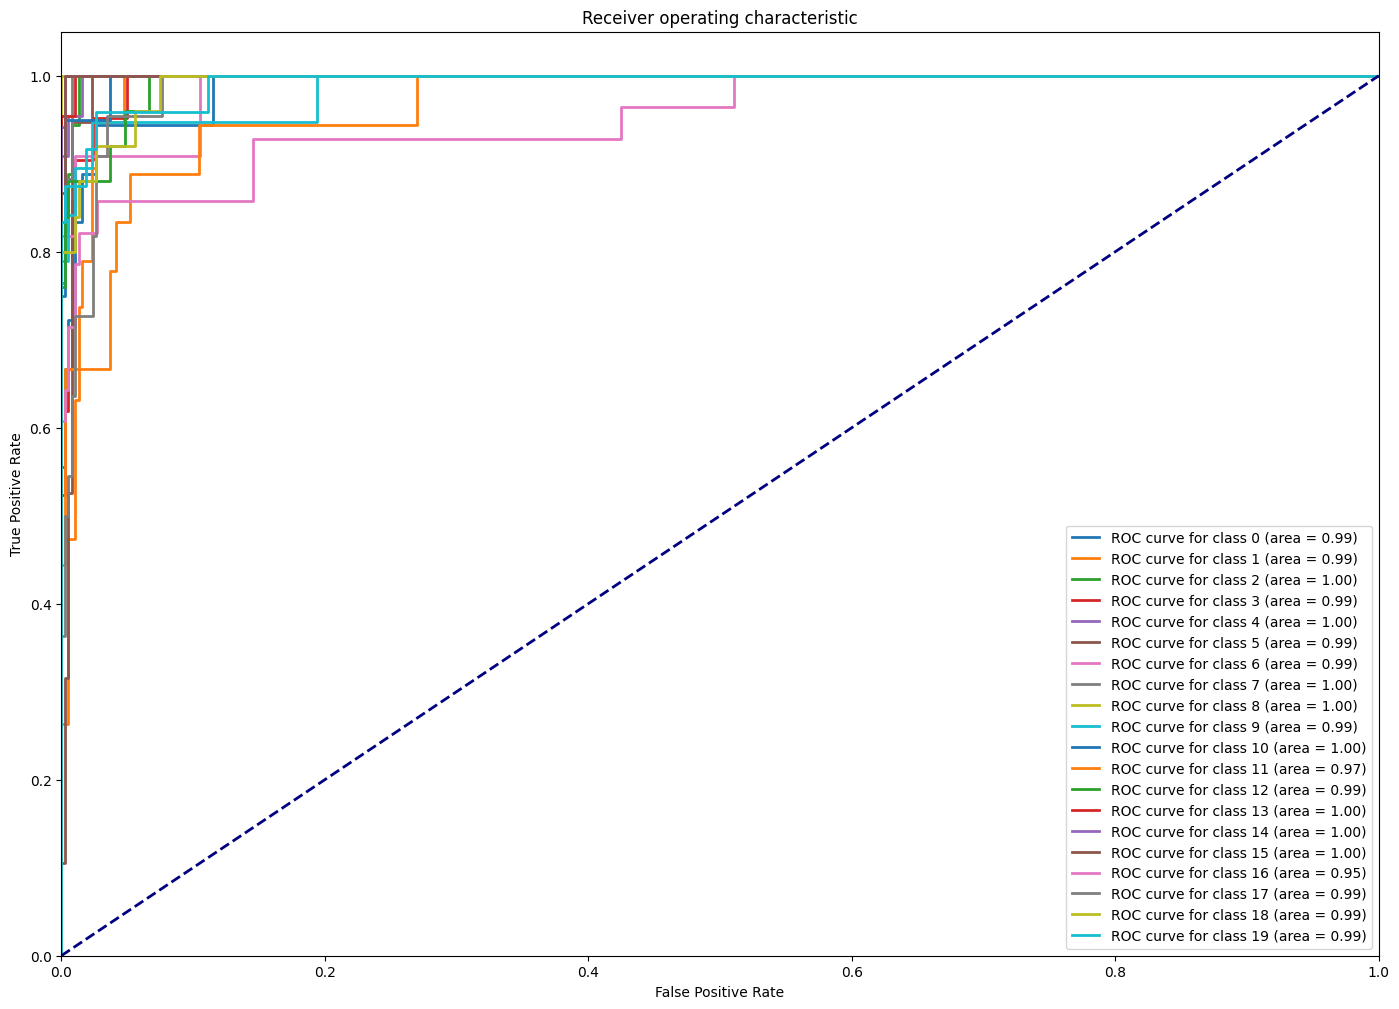

In [ ]:
plot_roc_curve(adda_real_prod, 'product')

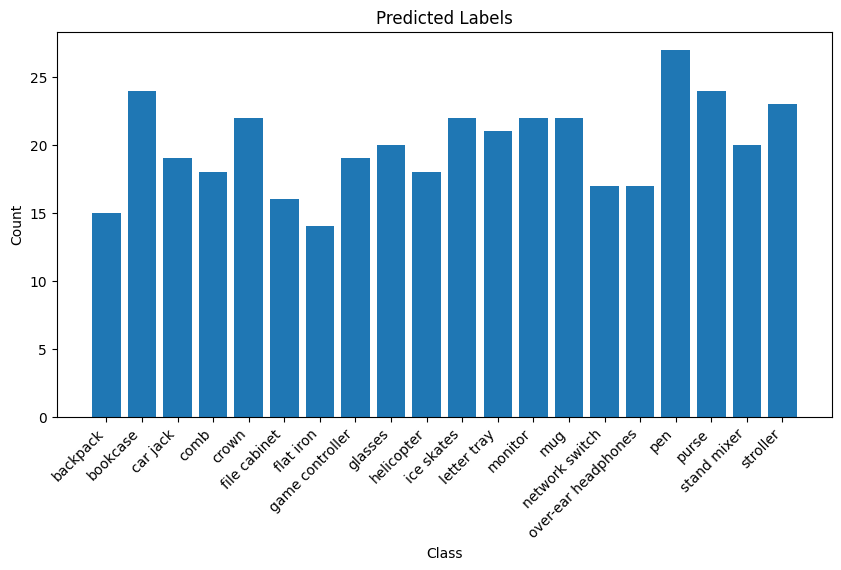

In [ ]:
plot_predicted_labels(adda_real_prod, 'product')

#### **Unsupervised Domain Adaptation by Backpropagation**

In order to try to achieve better results as well as to have, computationally speaking, a less expansive framework, we try here another approach, unseprvised domain adaptation by backpropagation.

As already pointed out, ADDA uses a generative adversarial network (GAN) to learn domain-invariant features from the source domain and then transfer these features to the target domain. In particular, it is made up of two networks: a domain classifier and a feature extractor. The domain classifier is taught to differentiate between the source and target domains, while the feature extractor is trained to extract domain-invariant features from the source domain. The two networks are trained in tandem using an adversarial approach, with the domain classifier attempting to accurately categorize the domain of the extracted features, while the feature extractor tries to trick the domain classifier by generating domain-invariant features. Once the feature extractor is trained, it can be used to extract features from the target domain and a classifier can be trained on these features.

On the other hand, UDA (through backpropagation) uses a single neural network with a modified loss function to learn domain-invariant features. Specifically, the network is trained on both the source and target domains using a modified cross-entropy loss function that includes a domain classification loss term. The domain classification loss encourages the network to learn features that are not specific to any particular domain, while the standard cross-entropy loss ensures that the network learns to classify the source domain correctly. Once the network is trained, it can be used to classify samples from the target domain.

In terms of performance, both UDA and ADDA have been shown to be effective in improving the performance of classifiers on target domains with limited labeled data. However, UDA (through backpropagation) has been shown to outperform ADDA on some benchmark datasets, such as Office-Home and VisDA-2017. UDA is also computationally less expensive than ADDA as it only requires training a single neural network, whereas ADDA requires training both a feature extractor and a domain classifier.

Deep domain adaptation is a method that seeks to incorporate domain adaptation and deep feature learning into an unique training process. This method's major objective is to incorporate domain adaptation into the learning process of the representation so that the final classification judgments may be made using features that are both discriminative and resilient to domain changes. In order for the neural network to be applicable to the target domain without being hampered by the shift between the two domains, the characteristics in the source and target domains should have the same or very comparable distributions.

The main idea is to unify domain adaptation into learning representations. Indeed this procedure implies at the same time optimizing the features as well as the classifiers which acts in a discriminative way on these same features. In particular, the first classifier is utilized both in the training and in the testing phase and its objective is to predict the labels of the different classes. Instead the other classifier aims at discerning among the source and the target domains within the training phase.

The various parameters of the above mentioned classifiers are set in a way that minimizes the error on the training set. On the other hand, regarding the feature mapping, the parameters try to maximize the loss calculated on the domain classifier.

A deep feedforward network with conventional layers and loss functions that was trained using conventional backpropagation algorithms based on stochastic gradient descent or its variants can incorporate the deep domain adaptation process. The domain classifier, label predictor, and feature extractor are the three components that make up this network. A feature extractor first converts the input x to a D-dimensional feature vector, which is subsequently converted to a label y and a domain label d. The method reduces label prediction loss on the annotated part of the training set (i.e., the source component) during training. The feature extractor and label predictor's parameters are both optimized to reduce empirical loss for source domain samples, ensuring the discriminativeness of the features and strong prediction performance on the source domain.

The strategy aims to make the features domain-invariant as well. Making the feature distributions from the source and target domains comparable allows for this. If the parameters of the domain classifier have been trained to optimally discriminate between the two feature distributions, the technique looks at the loss of the domain classifier to estimate the dissimilarity of the distributions. Making the two feature distributions as comparable as possible during training aims to maximize the loss of the domain classifier while simultaneously limiting the loss of the domain classifier and the loss of the label predictor.



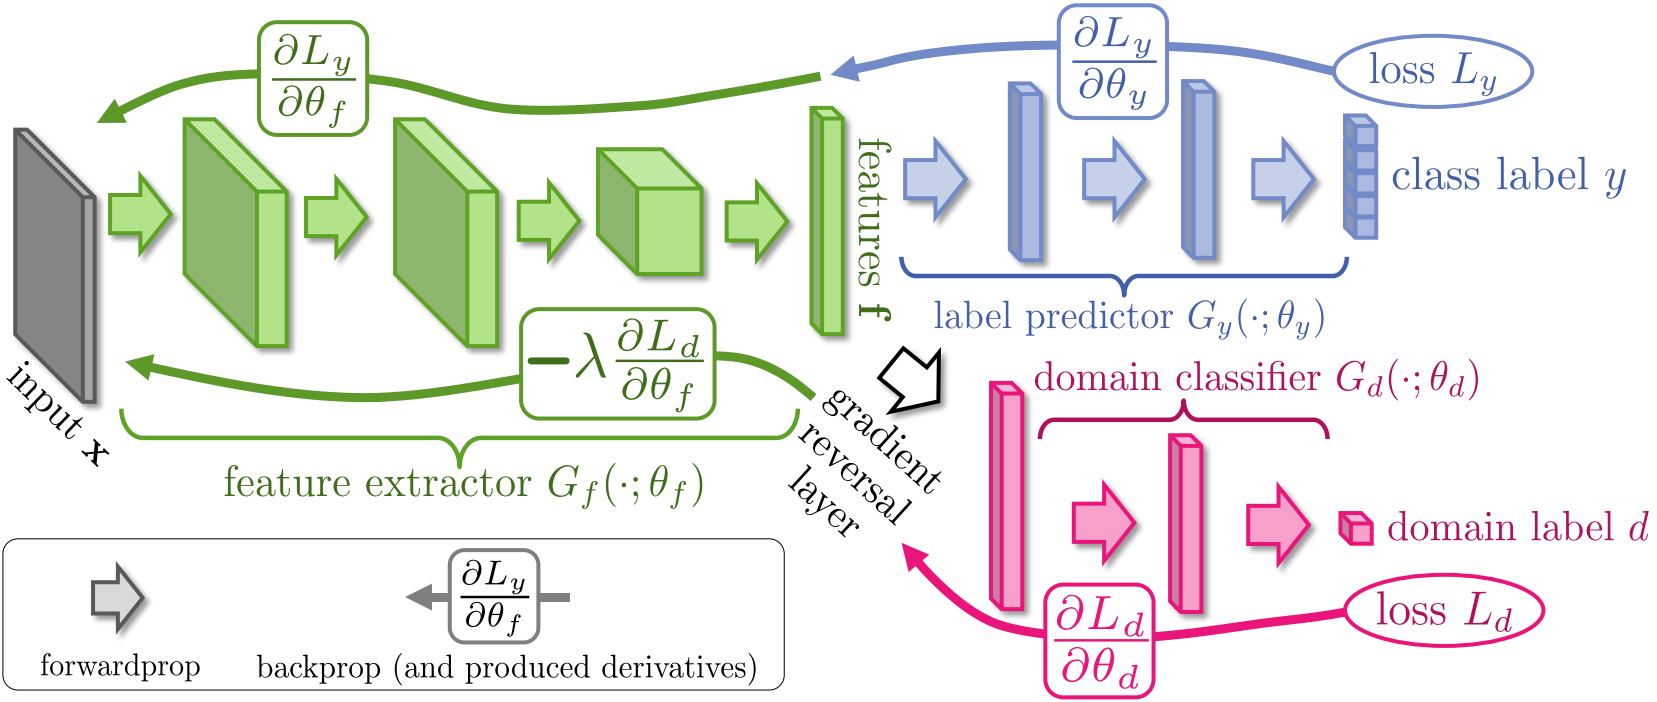

Arithmetically speaking we have: $E(θ_f, θ_y, θ_d)=∑ L_y (G_y ((G_f (x_i; θ_y), y_i) - λ ∑ (L_d (G_d (G_f (x_i; θ_f); θ_d), y_i) = ∑ (L_y)^i (θ_f, θ_y) - λ ∑ (L_d)^i (θ_f, θ_d)$

with $L_y$ the loss for the prediction of the labels, $L_d$ the loss for the classification of the domain, $(L_y)^i$ and $(L_d)^i$ the loss funtions for the $i_{th}$ training point.

The goal is to find the parameters $θ_f$, $θ_y$, $θ_d$ which allow a saddle point for the previous function: $θ_d = argmax E(θ_f, θ_y, θ_d)$

Here $θ_d$ minimizes the loss of the domain classification, on the other hand $θ_y$ the loss of the prediction of the labels. While maximizing the domain classification loss (i.e., the features are domain-invariant), the feature mapping parameters f minimize the label prediction loss (i.e., the features are discriminative). The trade-off between the two goals that mold the features during learning is controlled by the parameter.

In order to find the saddle point the stochastic updates are employed:

$θ_f ⟵ θ_f - μ (\frac{δL_y^i}  {δ θ_f} - λ \frac{δL_d^i}  {δ θ_f}) $

$θ_y ⟵ θ_y - μ \frac{δL_y^i}  {δ θ_y} $

$θ_d ⟵ θ_d - μ \frac{δL_d^i}  {δ θ_d} $

The formula used to update are close to the standard stochastic gradient descent employed during the training of a neural network. What differs is the presence of the factor $-λ$. Without it stochastic gradient descent would attempt to make features dissimilar across domains in order to reduce the loss of the domain classification.

In order to still apply the stochastic gradient descent, the so-called gradient reversal layer, GRL, is used. Besides $λ$, which is not updated by backpropagation, the gradient reversal layer has no associated parameters.

The GRL function serves as an identity transform during forward propagation while, during backpropagation, it multiplies the gradient from the succeeding level for the factor $-λ$ and gives it to the previous layer.

This GRL mechanism is placed among the domain classifier and the feature extractor.

After learning, labels for samples from both the source domain and the target domain can be predicted using the label predictor $y(x) = G_y(G_f(x; f); y)$.

In [ ]:
class GradientReversalFunction(Function):
    """
    Gradient Reversal Layer from:
    Unsupervised Domain Adaptation by Backpropagation (Ganin & Lempitsky, 2015)
    Forward pass is the identity function. In the backward pass,
    the upstream gradients are multiplied by -lambda (i.e. gradient is reversed)
    """

    @staticmethod
    def forward(ctx, x, lambda_):
        ctx.lambda_ = lambda_  # Save the lambda_ value in the context object
        return x.clone()

    @staticmethod
    def backward(ctx, grads):
        lambda_ = ctx.lambda_  # lambda_ value from the context object
        lambda_ = grads.new_tensor(lambda_)  # tensor with the same device as grads for lambda_
        dx = -lambda_ * grads  # Multiply gradients element-wise with -lambda_ to reverse them
        return dx, None


class GradientReversal(torch.nn.Module):
    def __init__(self, lambda_=1):
        super(GradientReversal, self).__init__()
        self.lambda_ = lambda_  # Initialize lambda_ (default 1)


    def forward(self, x):
        return GradientReversalFunction.apply(x, self.lambda_) # Apply the gradient reversal operation to the input and return the result

In [ ]:
def train_revgrad_step(model, discriminator, source_loader, target_loader, optimizer, device):

    # Set the models to training mode
    model.train()
    discriminator.train()

    #initiliaze variables to track the domain loss and the label accuract
    total_domain_loss = 0
    total_label_accuracy = 0

    #number of batches
    n_batches = min(len(source_loader), len(target_loader))

    #iterate over batches
    for (source_x, source_labels), (target_x, _) in tqdm(zip(source_loader, target_loader), leave=False, total=n_batches):

        #concatenate source_x and target_x
        x = torch.cat([source_x, target_x])
        x = x.to(device)

        #domain_y tensor (1s for source domain and 0s for target domain)
        domain_y = torch.cat([torch.ones(source_x.shape[0]), torch.zeros(target_x.shape[0])])
        domain_y = domain_y.to(device)
        label_y = source_labels.to(device)

        #feature extraction
        features = model.feature_extractor(x).view(x.shape[0], -1)
        #domain prediction with the discriminator
        domain_preds = discriminator(features).squeeze()
        #label prediction with the model classifier
        label_preds = model.classifier(features[:source_x.shape[0]])

        #domain loss and label loss calculation
        domain_loss = F.binary_cross_entropy_with_logits(domain_preds, domain_y)
        label_loss = F.cross_entropy(label_preds, label_y)
        loss = domain_loss + label_loss

        #gradients computation
        optimizer.zero_grad()
        loss.backward()
        #update the model and discriminator parameters with the optimizer accordingly on the computed gradients
        optimizer.step()


        total_domain_loss += domain_loss.item()
        total_label_accuracy += (label_preds.max(1)[1] == label_y).float().mean().item()

    average_loss = total_domain_loss / n_batches
    average_accuracy = total_label_accuracy / n_batches

    return average_loss, average_accuracy



In [ ]:
def train_revgrad(pathModel, batch_size, epochs, source, target, device):

    target_path = '/content/drive/MyDrive/deep/trained_models/revgrad_' + source + '_' + target + '.pth'

    # Initialize minimum loss to a large value
    min_loss = 10e6


    # Load the model's state_dict from Google Drive.
    state_dict = torch.load(pathModel)

    # Initialize the target model (ResNet18 with 20 output classes) and load the weights.
    model = ResNet18(20).to(device)
    model.load_state_dict(state_dict)

    model.eval()
    set_requires_grad(model, requires_grad=False)

    clf = model.classifier
    feature_extractor = model.feature_extractor

    #define the discriminator with a GradientReversal layer,
    # a linear layer with 512 input features and 64 output features,
    #a ReLU activation function, another linear layer with 64 input features and 20 output features,
    # another ReLU activation function, and a linear layer with 20 input features and 1 output feature

    discriminator = nn.Sequential(
        GradientReversal(),
        nn.Linear(512, 64),
        nn.ReLU(),
        nn.Linear(64, 20),
        nn.ReLU(),
        nn.Linear(20, 1)
    ).to(device)

    #create dataloaders for source data and target data with half the size of the batch
    half_batch = batch_size // 2

    source_loader = DataLoader(globals()[source + '_train_dataset'], batch_size=half_batch, shuffle=True, num_workers=1, pin_memory=True)
    target_loader = DataLoader(globals()[target + '_train_dataset'], batch_size=half_batch, shuffle=True, num_workers=1, pin_memory=True)

    #define optimizer with parameters of the discriminator and of the model
    optimizer = torch.optim.Adam(list(discriminator.parameters()) + list(model.parameters()))

    #training loop
    for epoch in range(1, epochs + 1):

        average_loss, average_accuracy = train_revgrad_step(model, discriminator, source_loader, target_loader, optimizer, device)

        print("Epoch {}/{}:".format(epoch, epochs))
        print("Average Loss:", average_loss)
        print("Average Accuracy:", average_accuracy)

        # Save the model if the loss has decreased.
        if average_loss < min_loss:
            torch.save(model.state_dict(), target_path)
            min_loss = average_loss

    print('Training Completed')
    print("Final Average loss:", average_loss)
    print("Final Average accuracy:", average_accuracy)

    return model

epochs = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



Real2Prod

In [ ]:
pathModel = "/content/drive/MyDrive/deep/trained_models/best_real_life_product.pth"
revgrad = train_revgrad(pathModel, batch_size, epochs, 'real_life', 'product', device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 140MB/s]


Epoch 1/32:
Mean Loss: 0.46197305619716644
Mean Accuracy: 0.9725


Epoch 2/32:
Mean Loss: 0.14015512891113757
Mean Accuracy: 0.97125


Epoch 3/32:
Mean Loss: 0.1029794155806303
Mean Accuracy: 0.973125


Epoch 4/32:
Mean Loss: 0.11495083589106798
Mean Accuracy: 0.976875


Epoch 5/32:
Mean Loss: 0.07228087060153485
Mean Accuracy: 0.974375


Epoch 6/32:
Mean Loss: 0.0773916383087635
Mean Accuracy: 0.971875


Epoch 7/32:
Mean Loss: 0.07801800649613141
Mean Accuracy: 0.971875


Epoch 8/32:
Mean Loss: 0.06196941856294871
Mean Accuracy: 0.969375


Epoch 9/32:
Mean Loss: 0.05669700618833304
Mean Accuracy: 0.97375


Epoch 10/32:
Mean Loss: 0.05830426346510649
Mean Accuracy: 0.97


Epoch 11/32:
Mean Loss: 0.04843038899824023
Mean Accuracy: 0.968125


Epoch 12/32:
Mean Loss: 0.04296627558767795
Mean Accuracy: 0.9775


Epoch 13/32:
Mean Loss: 0.04669624688103795
Mean Accuracy: 0.968125


Epoch 14/32:
Mean Loss: 0.048150991871953014
Mean Accuracy: 0.96875


Epoch 15/32:
Mean Loss: 0.0564258726593107
Mean Accuracy: 0.973125


Epoch 16/32:
Mean Loss: 0.05445036187767983
Mean Accuracy: 0.971875


Epoch 17/32:
Mean Loss: 0.04017346642911434
Mean Accuracy: 0.975


Epoch 18/32:
Mean Loss: 0.04591991840861738
Mean Accuracy: 0.975


Epoch 19/32:
Mean Loss: 0.041044313875027
Mean Accuracy: 0.974375


Epoch 20/32:
Mean Loss: 0.04281602004542947
Mean Accuracy: 0.97125


Epoch 21/32:
Mean Loss: 0.04071700190193951
Mean Accuracy: 0.974375


Epoch 22/32:
Mean Loss: 0.03916704637929797
Mean Accuracy: 0.97125


Epoch 23/32:
Mean Loss: 0.030881116343662144
Mean Accuracy: 0.97625


Epoch 24/32:
Mean Loss: 0.03623312226030975
Mean Accuracy: 0.97


Epoch 25/32:
Mean Loss: 0.041592413168400524
Mean Accuracy: 0.97125


Epoch 26/32:
Mean Loss: 0.02809840745758265
Mean Accuracy: 0.97375


Epoch 27/32:
Mean Loss: 0.03555115209426731
Mean Accuracy: 0.9725


Epoch 28/32:
Mean Loss: 0.03326608429197222
Mean Accuracy: 0.97625


Epoch 29/32:
Mean Loss: 0.0391599165275693
Mean Accuracy: 0.98


Epoch 30/32:
Mean Loss: 0.033661128906533125
Mean Accuracy: 0.975625


Epoch 31/32:
Mean Loss: 0.03156924664974212
Mean Accuracy: 0.9725


Epoch 32/32:
Mean Loss: 0.03447771339677274
Mean Accuracy: 0.970625
Training Completed
Final mean loss: 0.03447771339677274
Final mean accuracy: 0.970625


In [ ]:
y_true, y_pred = predict(revgrad, 'product', device='cuda')

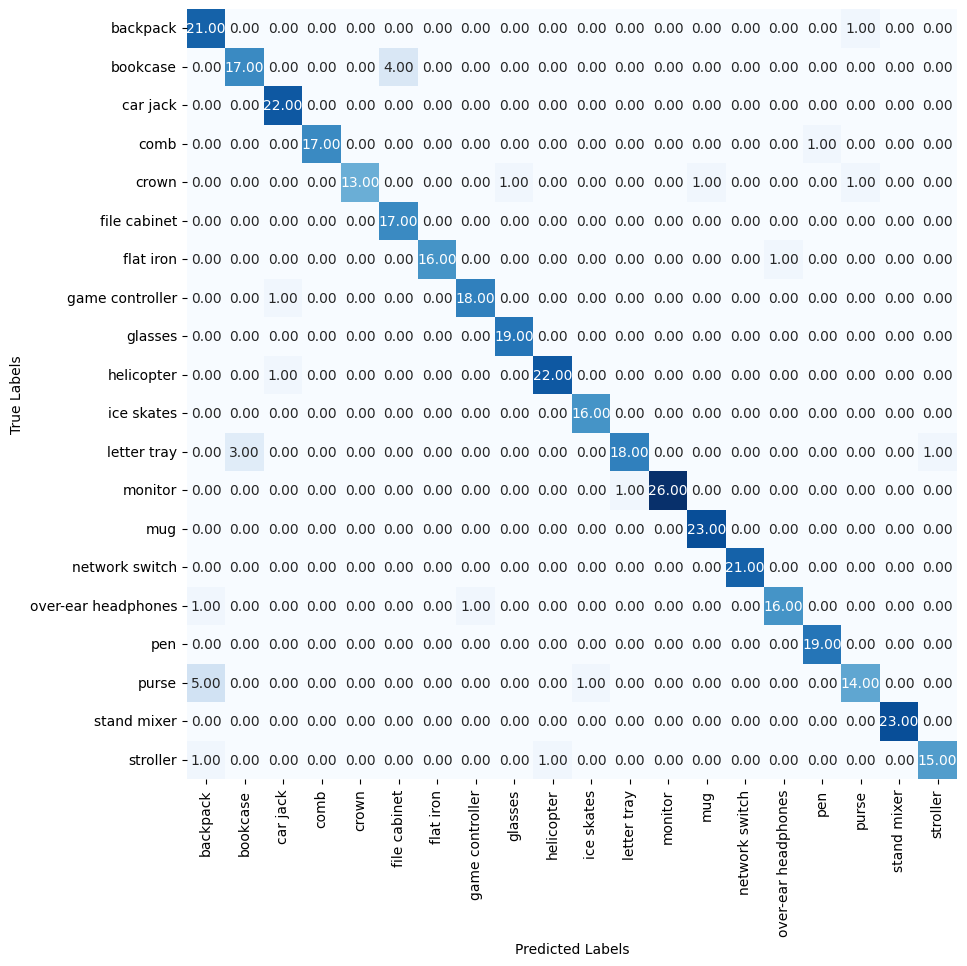

In [ ]:
plot_confusion_matrix(y_true, y_pred, classes)

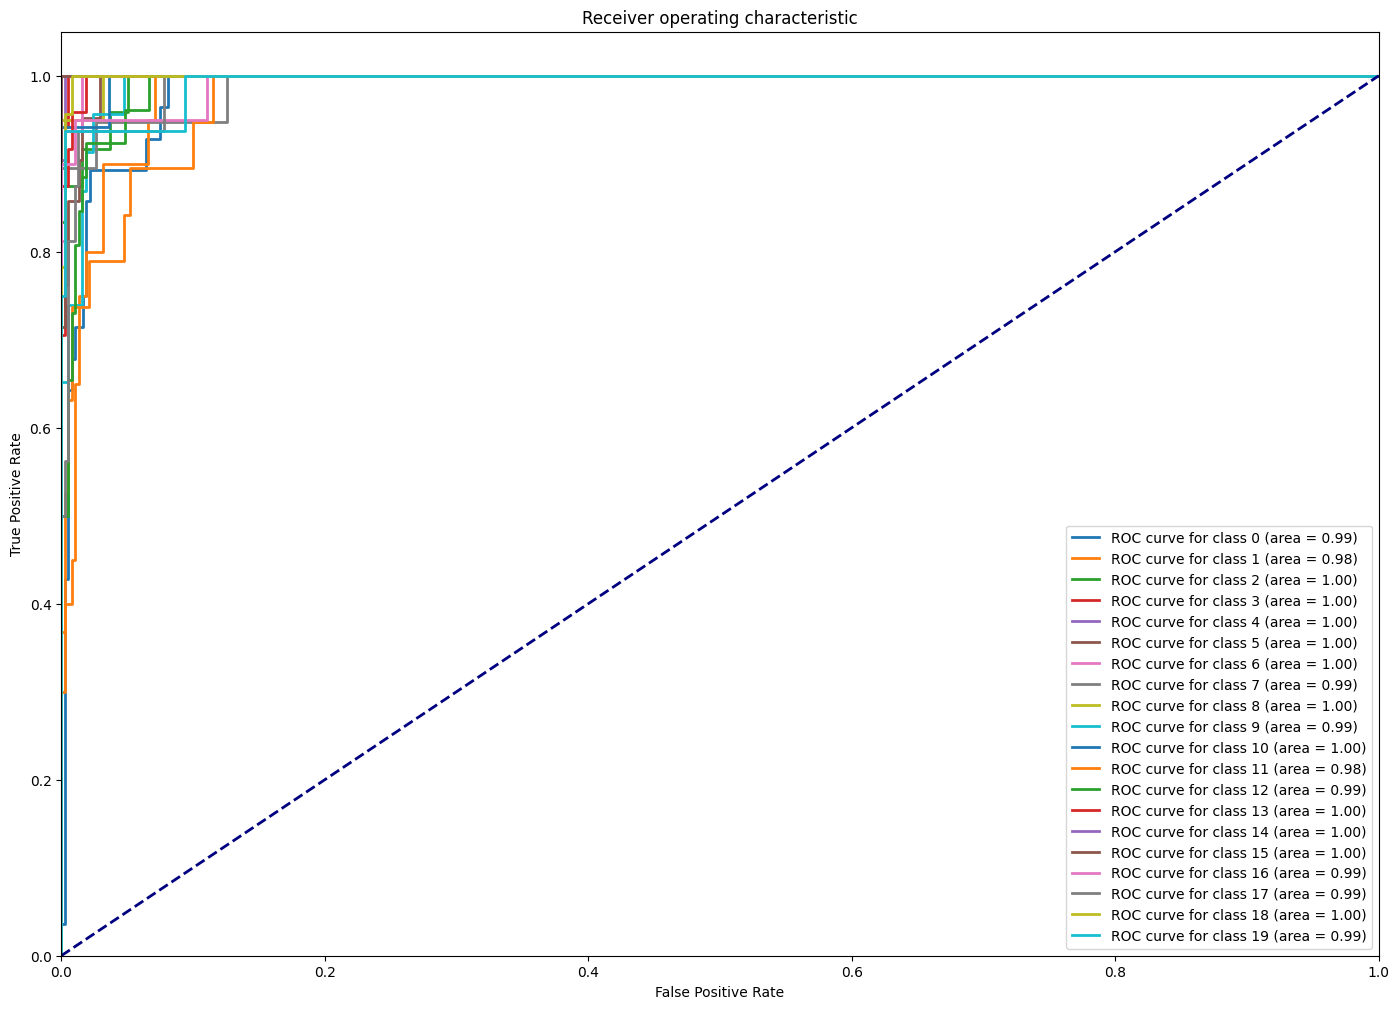

In [ ]:
plot_roc_curve(revgrad, 'product')

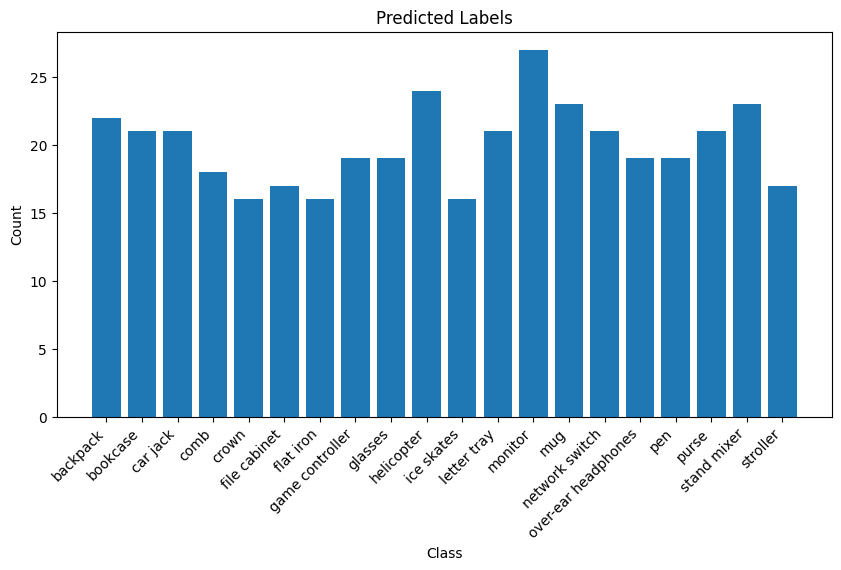

In [ ]:
plot_predicted_labels(revgrad, 'product')

Prod2Real

In [ ]:
pathModel = "/content/drive/MyDrive/deep/trained_models/best_product_real_life.pth"
revgrad = train_revgrad(pathModel, batch_size, epochs, 'product', 'real_life', device)

Epoch 1/32:
Mean Loss: 0.3884740403294563
Mean Accuracy: 0.984375


Epoch 2/32:
Mean Loss: 0.11259459994733334
Mean Accuracy: 0.9875


Epoch 3/32:
Mean Loss: 0.07755480777472258
Mean Accuracy: 0.990625


Epoch 4/32:
Mean Loss: 0.06681432832032443
Mean Accuracy: 0.99


Epoch 5/32:
Mean Loss: 0.053875900376588105
Mean Accuracy: 0.988125


Epoch 6/32:
Mean Loss: 0.04738247958943248
Mean Accuracy: 0.986875


Epoch 7/32:
Mean Loss: 0.042883270317688585
Mean Accuracy: 0.983125


Epoch 8/32:
Mean Loss: 0.04864723412785679
Mean Accuracy: 0.989375


Epoch 9/32:
Mean Loss: 0.03811722262762487
Mean Accuracy: 0.986875


Epoch 10/32:
Mean Loss: 0.029231809796765446
Mean Accuracy: 0.9875


Epoch 11/32:
Mean Loss: 0.03262195780873298
Mean Accuracy: 0.99


Epoch 12/32:
Mean Loss: 0.030129451607353985
Mean Accuracy: 0.98625


Epoch 13/32:
Mean Loss: 0.023525231706444175
Mean Accuracy: 0.99


Epoch 14/32:
Mean Loss: 0.04010675672674552
Mean Accuracy: 0.98875


Epoch 15/32:
Mean Loss: 0.03253982470370829
Mean Accuracy: 0.98875


Epoch 16/32:
Mean Loss: 0.040423949724063275
Mean Accuracy: 0.989375


Epoch 17/32:
Mean Loss: 0.027225680963601916
Mean Accuracy: 0.988125


Epoch 18/32:
Mean Loss: 0.025248159863986076
Mean Accuracy: 0.99


Epoch 19/32:
Mean Loss: 0.025293655532877893
Mean Accuracy: 0.986875


Epoch 20/32:
Mean Loss: 0.025302434279583393
Mean Accuracy: 0.98625


Epoch 21/32:
Mean Loss: 0.02503613234264776
Mean Accuracy: 0.98875


Epoch 22/32:
Mean Loss: 0.01973657756112516
Mean Accuracy: 0.989375


Epoch 23/32:
Mean Loss: 0.01856704181758687
Mean Accuracy: 0.986875


Epoch 24/32:
Mean Loss: 0.019713755630655215
Mean Accuracy: 0.98625


Epoch 25/32:
Mean Loss: 0.027415088375564663
Mean Accuracy: 0.99125


Epoch 26/32:
Mean Loss: 0.026799500500783325
Mean Accuracy: 0.988125


Epoch 27/32:
Mean Loss: 0.028749844105914236
Mean Accuracy: 0.988125


Epoch 28/32:
Mean Loss: 0.018654882996343075
Mean Accuracy: 0.98875


Epoch 29/32:
Mean Loss: 0.01887794475071132
Mean Accuracy: 0.98875


Epoch 30/32:
Mean Loss: 0.01335917252348736
Mean Accuracy: 0.98625


Epoch 31/32:
Mean Loss: 0.015502011536154896
Mean Accuracy: 0.991875


Epoch 32/32:
Mean Loss: 0.014177338003064506
Mean Accuracy: 0.99
Training Completed
Final mean loss: 0.014177338003064506
Final mean accuracy: 0.99


In [ ]:
y_true, y_pred = predict(revgrad, 'real_life', device='cuda')

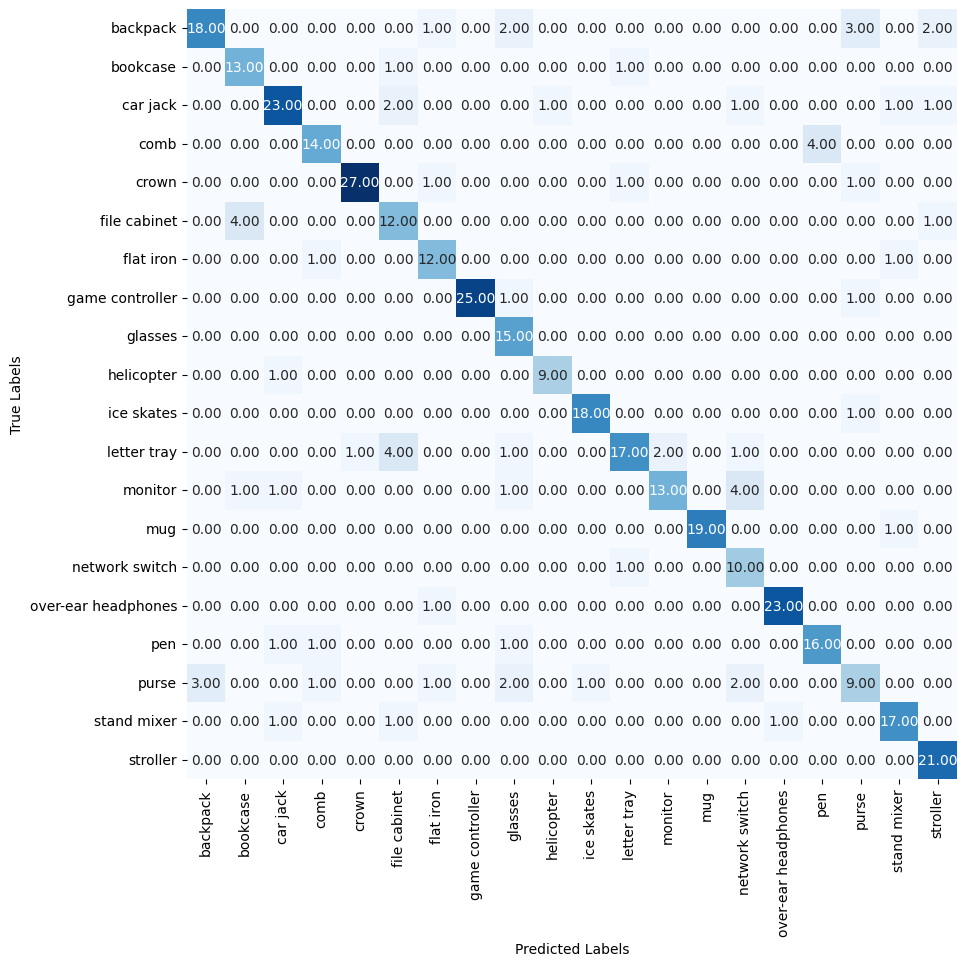

In [ ]:
plot_confusion_matrix(y_true, y_pred, classes)

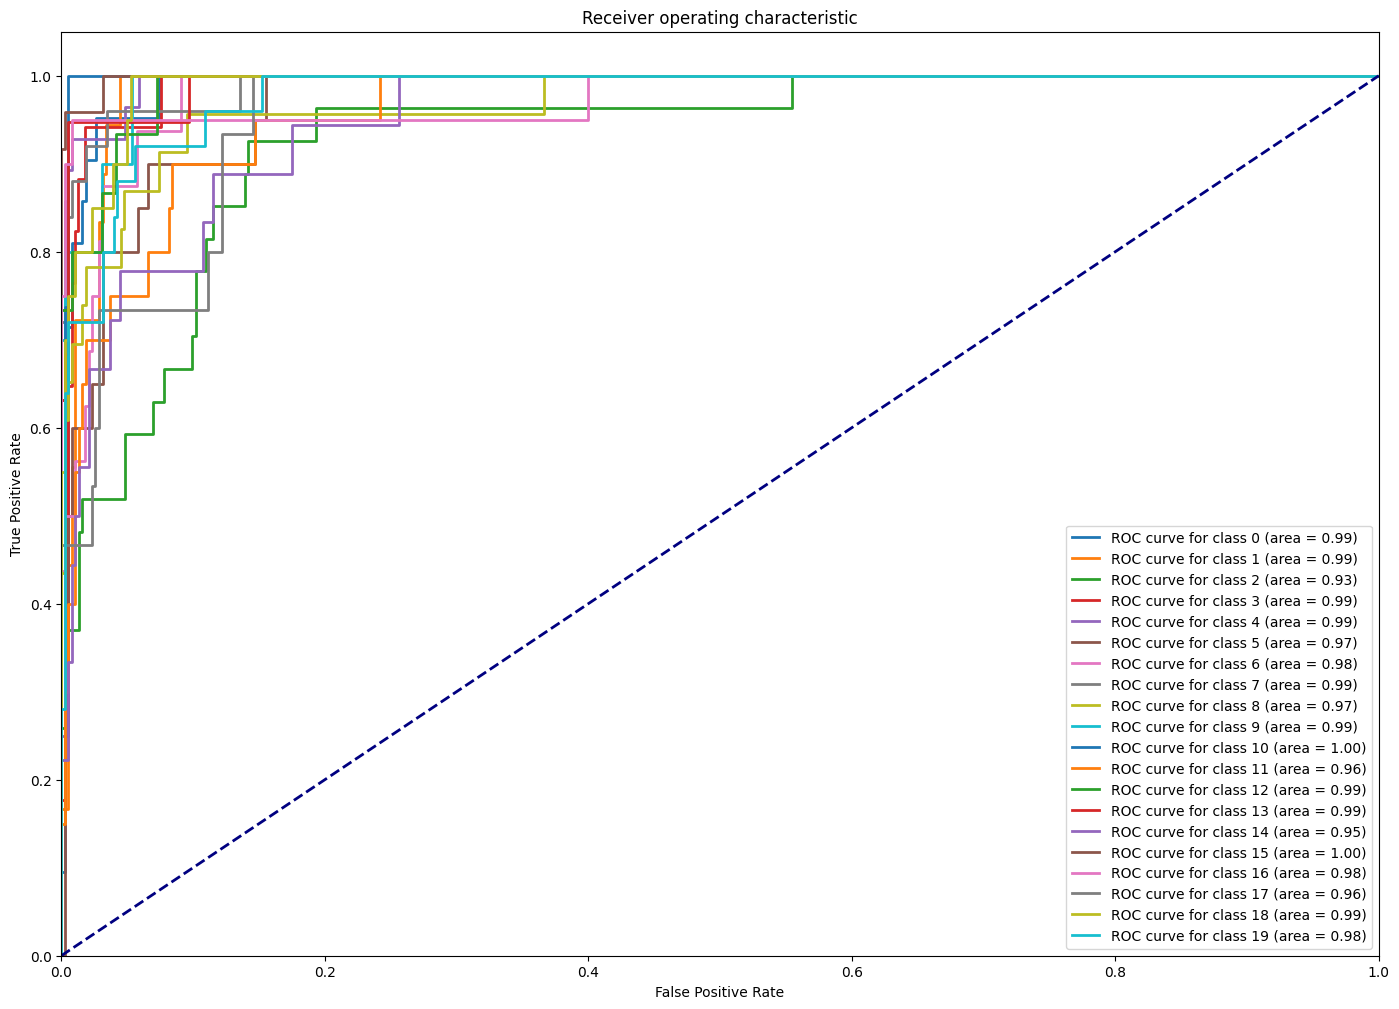

In [ ]:
plot_roc_curve(revgrad, 'real_life')

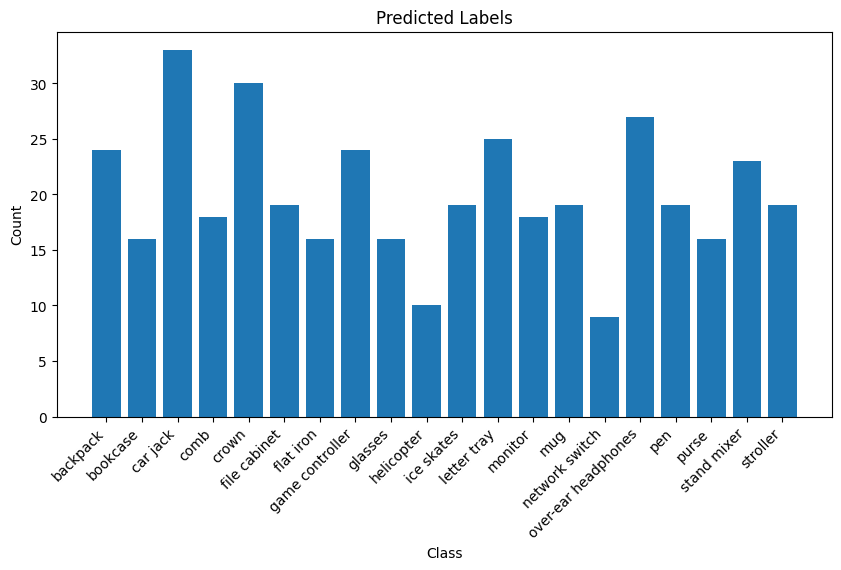

In [ ]:
plot_predicted_labels(revgrad, 'real_life')

In [ ]:
def test_model(MODEL_FILE, target, batch_size, device):
    # Create an instance of the ResNet18 model and move it to the device
    model = ResNet18(20).to(device)
    # Load model's state dictionary
    model.load_state_dict(torch.load(MODEL_FILE, map_location=device))
    # Set the model to evaluation mode
    model.eval()

    # Create a data loader for test data
    test_loader = DataLoader(globals()[target + '_test_dataset'], batch_size=batch_size, shuffle=False, num_workers=1, pin_memory=True)

    # Call test function to evaluate the model on the test data
    #loss, accuracy = test(model, test_loader, device)

    # Initialize variables for loss, accuracy, and sample
    total_loss = 0
    total_accuracy = 0
    total_samples = 0

    # Disable gradient calculation during testing
    with torch.no_grad():
        # Iterate over the data loader
        for data, labels in test_loader:
            # Move data and labels to device (GPU in this case)
            data = data.to(device)
            labels = labels.to(device)

            # Forward pass through the model
            output = model(data)

            # Compute loss using cross-entropy loss function
            loss = F.cross_entropy(output, labels)

            # Calculate predicted labels by selecting class with the highest probability
            preds = output.max(1)[1]

            # Calculate accuracy by comparing predicted labels with true labels
            accuracy = (preds == labels).float().mean()

            # Accumulate total loss, accuracy, and sample counts
            total_loss += loss.item() * data.size(0)
            total_accuracy += accuracy.item() * data.size(0)
            total_samples += data.size(0)

    # Compute loss and accuracy over all samples
    average_loss = total_loss / total_samples
    average_accuracy = total_accuracy / total_samples

    # Print test loss and accuracy
    print("Test Loss:", average_loss)
    print("Test Accuracy:", 100* average_accuracy, "%")

In [ ]:
# Testing
test_model("/content/drive/MyDrive/deep/trained_models/revgrad_product_real_life.pth", 'real_life', batch_size, device)

Test Loss: 0.7116405367851257
Test Accuracy: 81.0 %


In [ ]:
# Testing
test_model("/content/drive/MyDrive/deep/trained_models/revgrad_product_real_life.pth", 'product', batch_size, device)

Test Loss: 0.05310767835006118
Test Accuracy: 99.75 %


In [ ]:
# Testing
test_model("/content/drive/MyDrive/deep/trained_models/revgrad_real_life_product.pth", 'product', batch_size, device)

Test Loss: 0.20538013219833373
Test Accuracy: 94.5 %


In [ ]:
# Testing
test_model("/content/drive/MyDrive/deep/trained_models/revgrad_real_life_product.pth", 'real_life', batch_size, device)

Test Loss: 0.09319036111235618
Test Accuracy: 98.0 %


Due to different datasets due to having to use different gpu's we recalculate the test accuracy

Baseline

In [ ]:
# Testing Real2Product
test_model("/content/drive/MyDrive/deep/trained_models/best_real_life_product.pth", 'product', batch_size, device)

Test Loss: 0.2473401552438736
Test Accuracy: 92.5 %


In [ ]:
# Testing Prod2Prod
test_model("/content/drive/MyDrive/deep/trained_models/best_product_product.pth", 'product', batch_size, device)

Test Loss: 0.03042764836922288
Test Accuracy: 99.75 %


In [ ]:
# Testing Prod2Real
test_model("/content/drive/MyDrive/deep/trained_models/best_product_real_life.pth", 'real_life', batch_size, device)

Test Loss: 0.8647405219078064
Test Accuracy: 74.25 %


In [ ]:
# Testing Real2Real
test_model("/content/drive/MyDrive/deep/trained_models/best_real_life_real_life.pth", 'real_life', batch_size, device)

Test Loss: 0.08237167082726955
Test Accuracy: 98.75 %


Pseudo Labels

In [ ]:
# Testing Prod2Real
test_model("/content/drive/MyDrive/deep/trained_models/pseudo_lab_product_real_life.pth", 'real_life', batch_size, device)

Test Loss: 0.6345224273204804
Test Accuracy: 82.0 %


In [ ]:
# Testing Real2Prod
test_model("/content/drive/MyDrive/deep/trained_models/pseudo_lab_real_life_product.pth", 'product', batch_size, device)

Test Loss: 0.2043249700218439
Test Accuracy: 93.75 %


ADDA

In [ ]:
# Testing Prod2Real
test_model("/content/drive/MyDrive/deep/trained_models/adda_product_real_life.pth", 'real_life', batch_size, device)

Test Loss: 0.6359145903587341
Test Accuracy: 83.25 %


In [ ]:
# Testing Real2Prod
test_model("/content/drive/MyDrive/deep/trained_models/adda_real_life_product.pth", 'product', batch_size, device)

Test Loss: 0.26578483238816264
Test Accuracy: 91.0 %


RevGrad

In [ ]:
# Testing Prod2Real
test_model("/content/drive/MyDrive/deep/trained_models/revgrad_product_real_life.pth", 'real_life', batch_size, device)

Test Loss: 0.6962421345710754
Test Accuracy: 81.75 %


In [ ]:
# Testing Real2Prod
test_model("/content/drive/MyDrive/deep/trained_models/revgrad_real_life_product.pth", 'product', batch_size, device)

Test Loss: 0.21453641444444657
Test Accuracy: 94.5 %


### **Fourth step**

### Conclusions

With this project we wanted to implement solutions for Unsupervised Domain Adaptation.

We started from a baseline, the Resnet 18 network with the purpose of implementing new methods that could improve the results obtained from this.
We implemented three methods: the first one using pseudo labels, a method that assigns pseudo labels to the target domain data based on the predictions of the source domain model to fine-tune the final model, the second using ADDA (Adversarial Discriminative Domain Adaptation), thus using adversarial learning to reduce the domain discrepancy between the source and the target domain and the third one using backpropagation with a gradient reversal layer that reverse the sign of the gradient during backpropagation with the aim of bringing out features independent of the domain.

Here below we summarize our results:
- ResNet18 (Baseline):
  - Product -> Real life: 74.25%
  - Real life -> Product: 92.50%
- Pseudo Labels:
  - Product -> Real life: 82.00%
  - Real life -> Product: 93.75%
- ADDA (Adversarial Discriminative Domain Adaptation):
  - Product -> Real life: 83.25
  - Real life -> Product: 91.00%
- Unsupervised domain adaptation by Backpropagation (RevGrad):
  - Product -> Real life: 81.75%
  - Real life -> Product: 94.50%

In general, it is interesting to note that in all four cases training the network on the product dataset the model tends to overfit on it, probably due to the background of these images being solid-colored which allows for less generic feature extraction than object images taken in real-world contexts, however, it is in this case that we can best see the improvement brought by the domain adaptation methods we implemented.

